# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/21/20


,3/21/20
Country/Region,
China,81305
Italy,53578
US,25489
Spain,25374
Germany,22213
Iran,20610
France,14431
"Korea, South",8799
Switzerland,6575


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 81305
	Confirmed cases on 3/14/20 	 80977
	Ratio: 1.0
	Weekly increase: 0.4 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 1200.3 days

** Based on Logistic Fit**

	R^2: 0.995419395456
	Doubling Time (during middle of growth):  6.47 (± 0.53 ) days


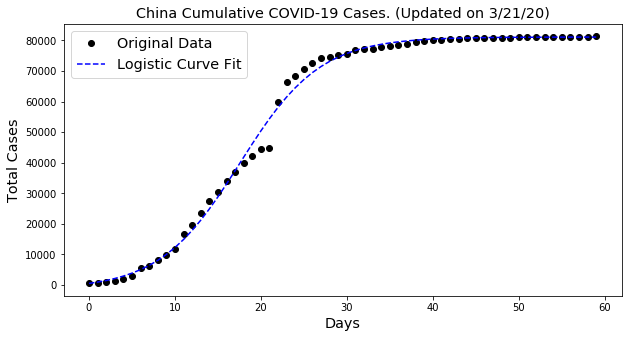



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 53578
	Confirmed cases on 3/14/20 	 21157
	Ratio: 2.53
	Weekly increase: 153.2 %
	Daily increase: 14.2 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.998844116247
	Doubling Time (during middle of growth):  7.19 (± 0.41 ) days

** Based on Exponential Fit **

	R^2: 0.995810887722
	Doubling Time (represents overall growth):  4.61 (± 0.18 ) days


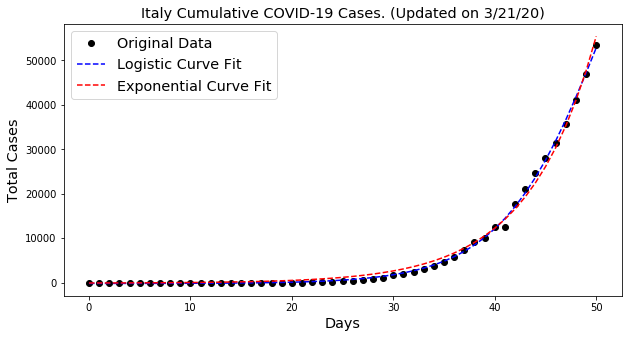



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 25489
	Confirmed cases on 3/14/20 	 2727
	Ratio: 9.35
	Weekly increase: 834.7 %
	Daily increase: 37.6 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.996517167012
	Doubling Time (represents overall growth):  2.04 (± 0.06 ) days


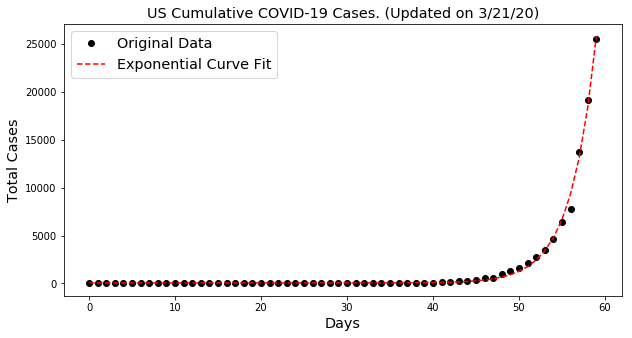



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 25374
	Confirmed cases on 3/14/20 	 6391
	Ratio: 3.97
	Weekly increase: 297.0 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.993363208327
	Doubling Time (represents overall growth):  3.26 (± 0.16 ) days


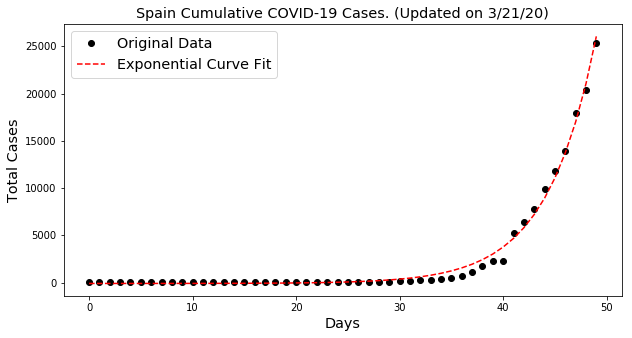



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 22213
	Confirmed cases on 3/14/20 	 4585
	Ratio: 4.84
	Weekly increase: 384.5 %
	Daily increase: 25.3 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.996130895681
	Doubling Time (represents overall growth):  3.01 (± 0.1 ) days


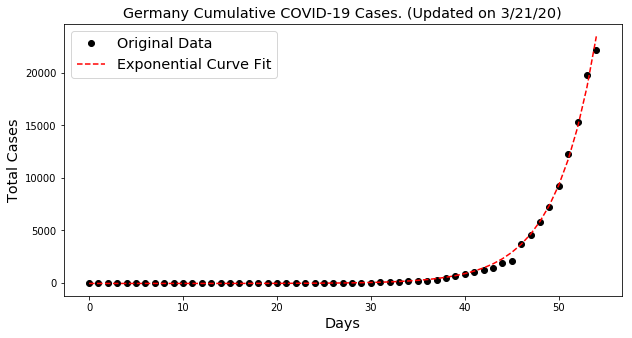



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 20610
	Confirmed cases on 3/14/20 	 12729
	Ratio: 1.62
	Weekly increase: 61.9 %
	Daily increase: 7.1 % per day
	Doubling Time (represents recent growth): 10.1 days

** Based on Logistic Fit**

	R^2: 0.99790015231
	Doubling Time (during middle of growth):  7.54 (± 0.78 ) days


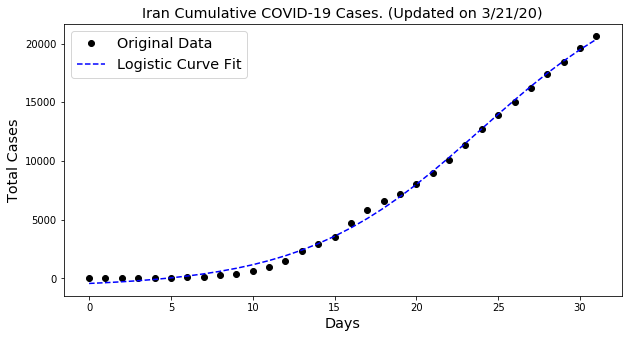



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 14431
	Confirmed cases on 3/14/20 	 4487
	Ratio: 3.22
	Weekly increase: 221.6 %
	Daily increase: 18.2 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Exponential Fit **

	R^2: 0.994937474048
	Doubling Time (represents overall growth):  3.79 (± 0.15 ) days


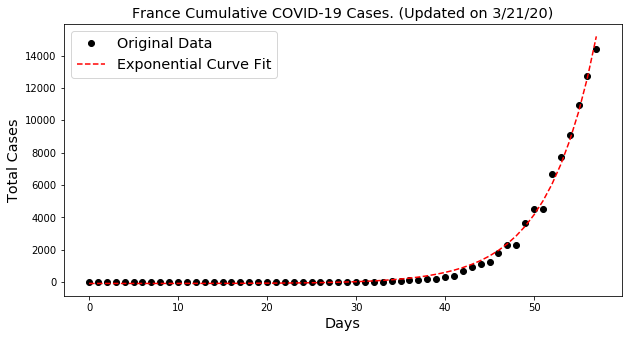



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 8799
	Confirmed cases on 3/14/20 	 8086
	Ratio: 1.09
	Weekly increase: 8.8 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.4 days

** Based on Logistic Fit**

	R^2: 0.998834631645
	Doubling Time (during middle of growth):  4.34 (± 0.19 ) days


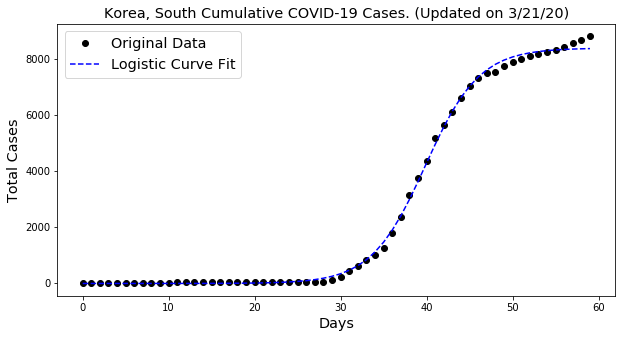



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 6575
	Confirmed cases on 3/14/20 	 1359
	Ratio: 4.84
	Weekly increase: 383.8 %
	Daily increase: 25.3 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.994671819686
	Doubling Time (during middle of growth):  6.33 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.99467181986
	Doubling Time (represents overall growth):  3.16 (± 0.22 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


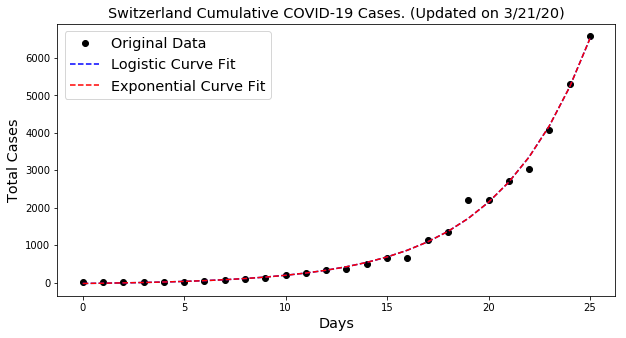



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 5067
	Confirmed cases on 3/14/20 	 1144
	Ratio: 4.43
	Weekly increase: 342.9 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.995147184694
	Doubling Time (represents overall growth):  2.93 (± 0.12 ) days


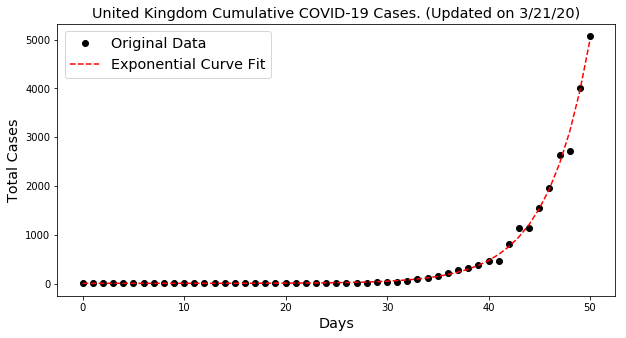



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 3640
	Confirmed cases on 3/14/20 	 962
	Ratio: 3.78
	Weekly increase: 278.4 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.999142519657
	Doubling Time (during middle of growth):  7.03 (± 0.8 ) days

** Based on Exponential Fit **

	R^2: 0.999090690711
	Doubling Time (represents overall growth):  3.74 (± 0.12 ) days


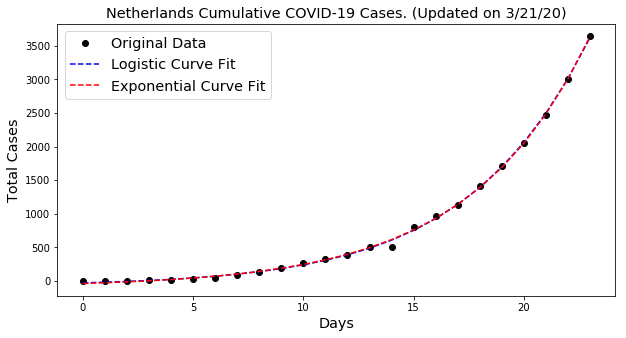



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 2815
	Confirmed cases on 3/14/20 	 689
	Ratio: 4.09
	Weekly increase: 308.6 %
	Daily increase: 22.3 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.997591912445
	Doubling Time (represents overall growth):  3.37 (± 0.1 ) days


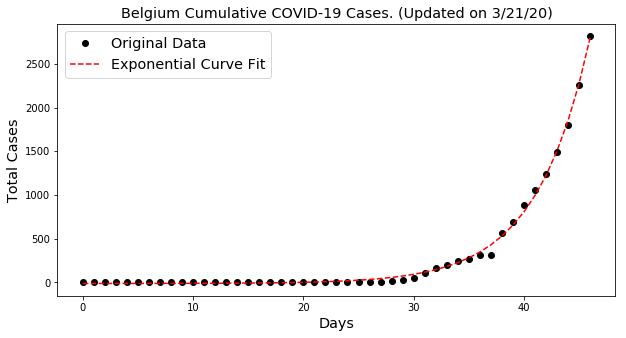



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 2814
	Confirmed cases on 3/14/20 	 655
	Ratio: 4.3
	Weekly increase: 329.6 %
	Daily increase: 23.2 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.999447549352
	Doubling Time (during middle of growth):  4.52 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.995471501829
	Doubling Time (represents overall growth):  3.41 (± 0.22 ) days


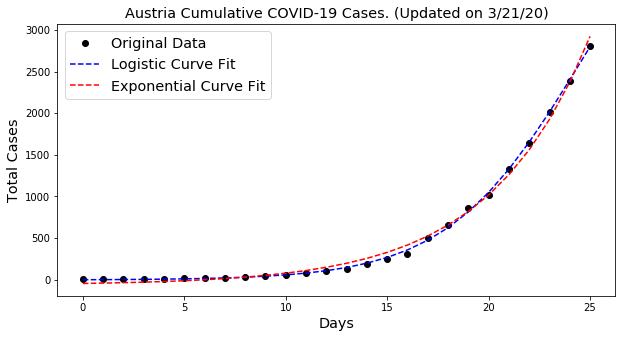



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 2118
	Confirmed cases on 3/14/20 	 1090
	Ratio: 1.94
	Weekly increase: 94.3 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.992369268057
	Doubling Time (during middle of growth):  4.64 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.965019756351
	Doubling Time (represents overall growth):  5.22 (± 1.25 ) days


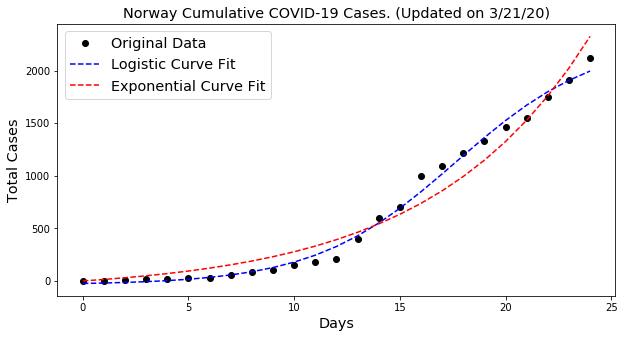



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1763
	Confirmed cases on 3/14/20 	 961
	Ratio: 1.83
	Weekly increase: 83.5 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.994458655729
	Doubling Time (during middle of growth):  4.76 (± 0.5 ) days

** Based on Exponential Fit **

	R^2: 0.974096915795
	Doubling Time (represents overall growth):  5.25 (± 0.53 ) days


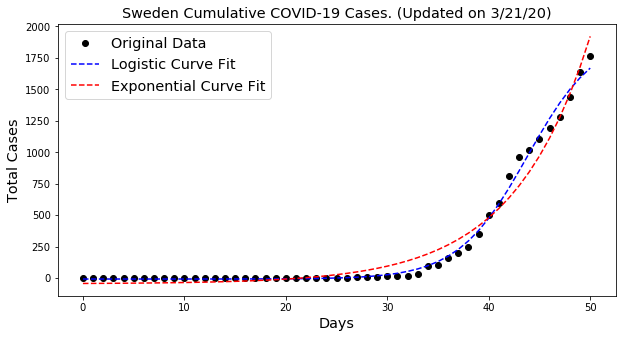



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1420
	Confirmed cases on 3/14/20 	 836
	Ratio: 1.7
	Weekly increase: 69.9 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.9823491197
	Doubling Time (during middle of growth):  3.53 (± 0.97 ) days


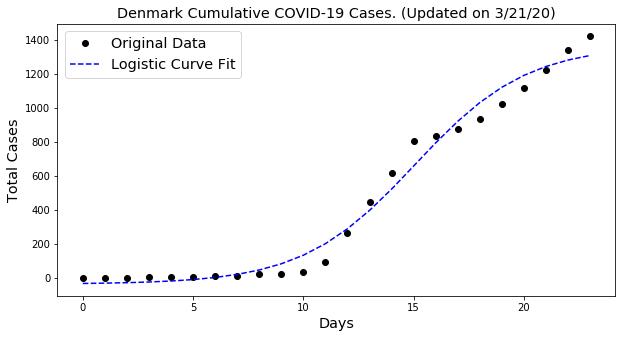



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1280
	Confirmed cases on 3/14/20 	 169
	Ratio: 7.57
	Weekly increase: 657.4 %
	Daily increase: 33.5 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.993144342114
	Doubling Time (during middle of growth):  4.25 (± 1.23 ) days

** Based on Exponential Fit **

	R^2: 0.992751267004
	Doubling Time (represents overall growth):  2.45 (± 0.23 ) days


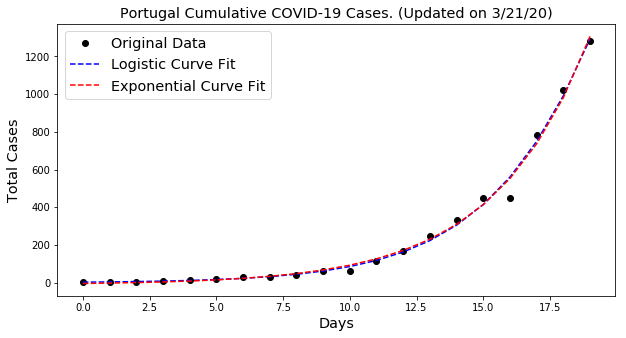



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1278
	Confirmed cases on 3/14/20 	 198
	Ratio: 6.45
	Weekly increase: 545.5 %
	Daily increase: 30.5 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Exponential Fit **

	R^2: 0.996673944696
	Doubling Time (represents overall growth):  2.82 (± 0.09 ) days


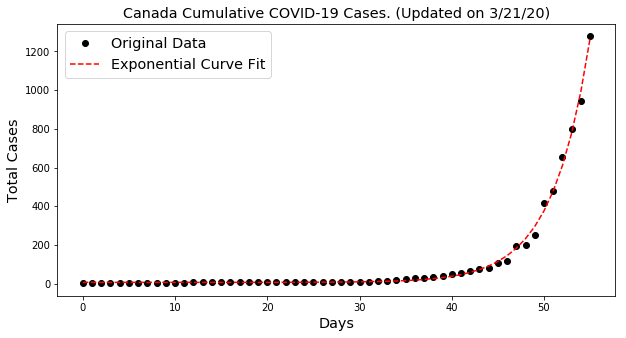



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1183
	Confirmed cases on 3/14/20 	 238
	Ratio: 4.97
	Weekly increase: 397.1 %
	Daily increase: 25.7 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.986348377976
	Doubling Time (represents overall growth):  3.58 (± 0.23 ) days


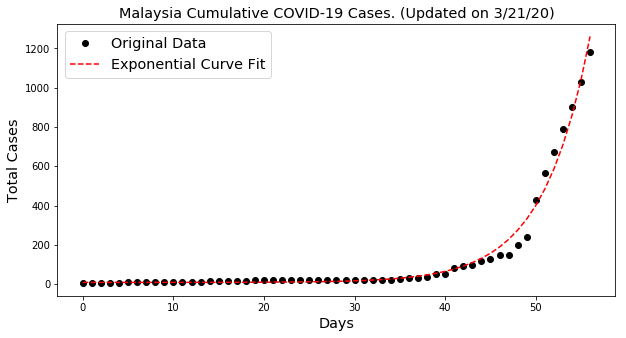



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1071
	Confirmed cases on 3/14/20 	 250
	Ratio: 4.28
	Weekly increase: 328.4 %
	Daily increase: 23.1 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.997644807363
	Doubling Time (represents overall growth):  3.21 (± 0.09 ) days


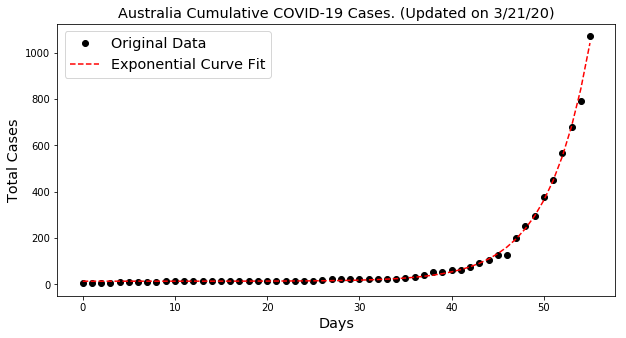



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1021
	Confirmed cases on 3/14/20 	 151
	Ratio: 6.76
	Weekly increase: 576.2 %
	Daily increase: 31.4 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.993685581517
	Doubling Time (during middle of growth):  4.28 (± 0.98 ) days

** Based on Exponential Fit **

	R^2: 0.993523018337
	Doubling Time (represents overall growth):  2.33 (± 0.17 ) days


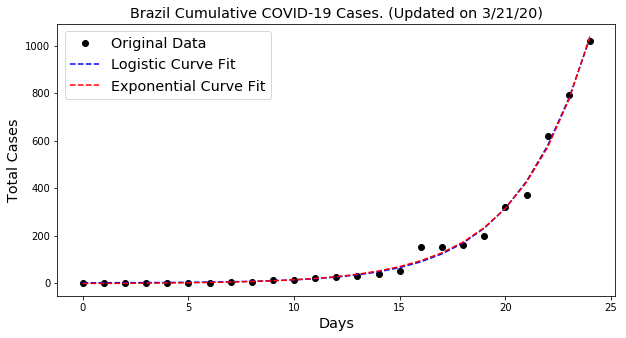



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1007
	Confirmed cases on 3/14/20 	 773
	Ratio: 1.3
	Weekly increase: 30.3 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.3 days

** Based on Logistic Fit**

	R^2: 0.997929915555
	Doubling Time (during middle of growth):  10.98 (± 0.72 ) days

** Based on Exponential Fit **

	R^2: 0.987792786064
	Doubling Time (represents overall growth):  11.36 (± 0.9 ) days


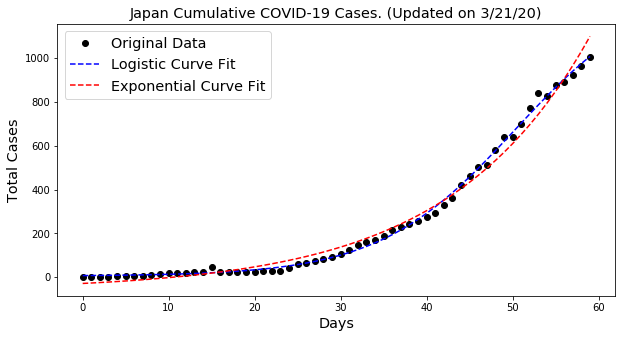



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 995
	Confirmed cases on 3/14/20 	 189
	Ratio: 5.26
	Weekly increase: 426.5 %
	Daily increase: 26.8 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.996702740592
	Doubling Time (during middle of growth):  4.66 (± 0.88 ) days

** Based on Exponential Fit **

	R^2: 0.995575049962
	Doubling Time (represents overall growth):  2.98 (± 0.22 ) days


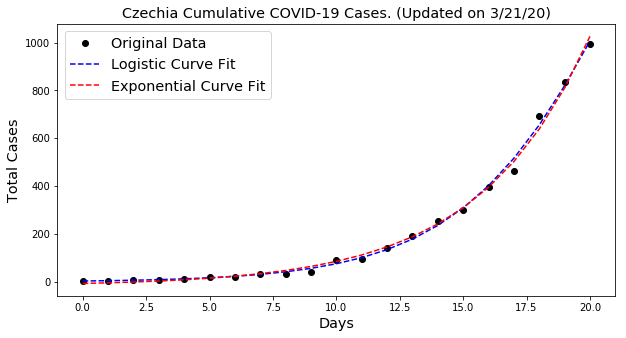



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 883
	Confirmed cases on 3/14/20 	 193
	Ratio: 4.58
	Weekly increase: 357.5 %
	Daily increase: 24.3 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.990708182485
	Doubling Time (during middle of growth):  6.01 (± 1.58 ) days

** Based on Exponential Fit **

	R^2: 0.990660857706
	Doubling Time (represents overall growth):  3.15 (± 0.26 ) days


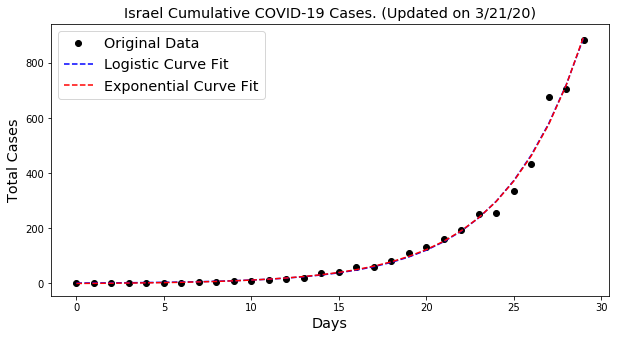



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 785
	Confirmed cases on 3/14/20 	 129
	Ratio: 6.09
	Weekly increase: 508.5 %
	Daily increase: 29.4 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.986004226026
	Doubling Time (during middle of growth):  3.0 (± 0.93 ) days

** Based on Exponential Fit **

	R^2: 0.981620922679
	Doubling Time (represents overall growth):  2.39 (± 0.33 ) days


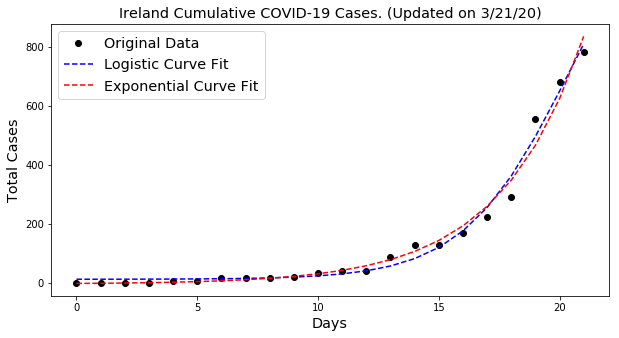



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 730
	Confirmed cases on 3/14/20 	 31
	Ratio: 23.55
	Weekly increase: 2254.8 %
	Daily increase: 57.0 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Exponential Fit **

	R^2: 0.985218292983
	Doubling Time (represents overall growth):  2.16 (± 0.24 ) days


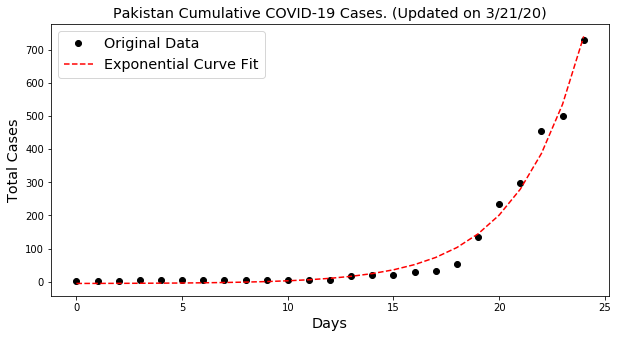



Cruise Ship

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 712
	Confirmed cases on 3/14/20 	 696
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 213.5 days

** Based on Logistic Fit**

	R^2: 0.995641027365
	Doubling Time (during middle of growth):  2.71 (± 0.27 ) days


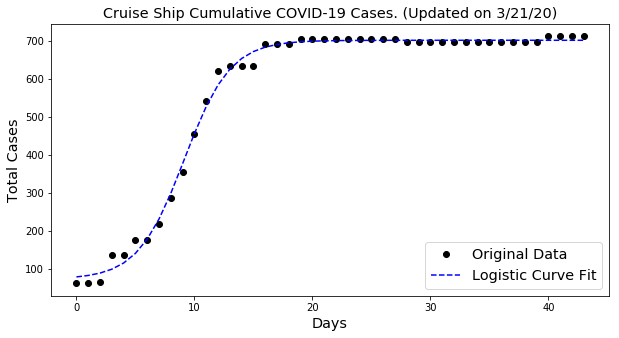



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 670
	Confirmed cases on 3/14/20 	 5
	Ratio: 134.0
	Weekly increase: 13300.0 %
	Daily increase: 101.3 % per day
	Doubling Time (represents recent growth): 1.0 days

** Based on Logistic Fit**

	R^2: 0.999785596013
	Doubling Time (during middle of growth):  2.01 (± 0.18 ) days

** Based on Exponential Fit **

	R^2: 0.999638392786
	Doubling Time (represents overall growth):  1.1 (± 0.03 ) days


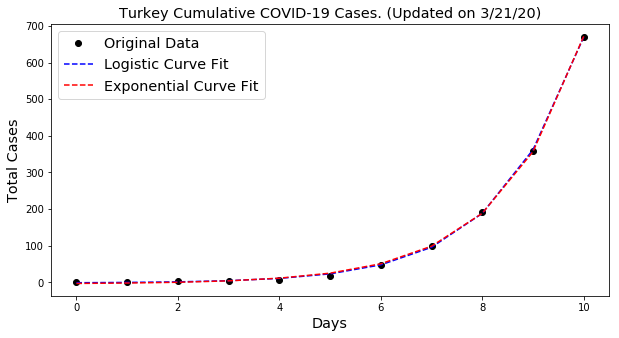



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 670
	Confirmed cases on 3/14/20 	 51
	Ratio: 13.14
	Weekly increase: 1213.7 %
	Daily increase: 44.5 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.997416668695
	Doubling Time (represents overall growth):  1.8 (± 0.09 ) days


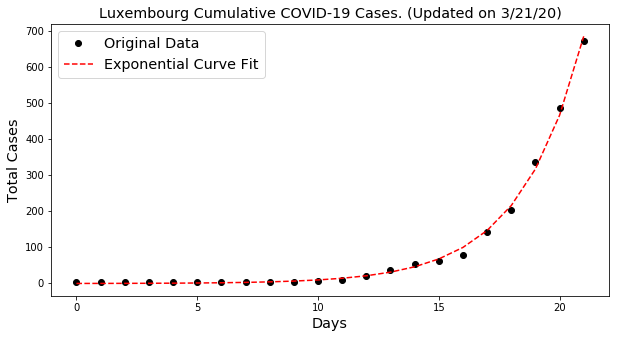



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 537
	Confirmed cases on 3/14/20 	 61
	Ratio: 8.8
	Weekly increase: 780.3 %
	Daily increase: 36.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.982226174277
	Doubling Time (during middle of growth):  4.87 (± 2.75 ) days

** Based on Exponential Fit **

	R^2: 0.982226174817
	Doubling Time (represents overall growth):  2.44 (± 0.38 ) days


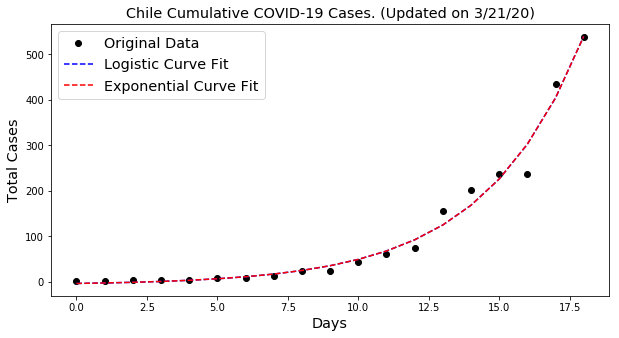



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 536
	Confirmed cases on 3/14/20 	 103
	Ratio: 5.2
	Weekly increase: 420.4 %
	Daily increase: 26.6 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.996473966066
	Doubling Time (during middle of growth):  5.06 (± 1.3 ) days

** Based on Exponential Fit **

	R^2: 0.995822912454
	Doubling Time (represents overall growth):  3.18 (± 0.28 ) days


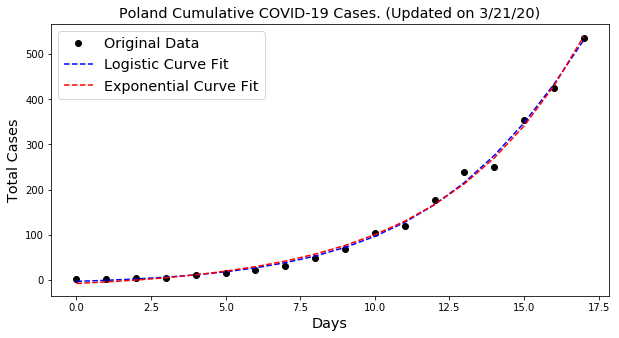



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 530
	Confirmed cases on 3/14/20 	 228
	Ratio: 2.32
	Weekly increase: 132.5 %
	Daily increase: 12.8 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Logistic Fit**

	R^2: 0.989004192627
	Doubling Time (during middle of growth):  4.05 (± 0.91 ) days

** Based on Exponential Fit **

	R^2: 0.971037220268
	Doubling Time (represents overall growth):  6.09 (± 1.43 ) days


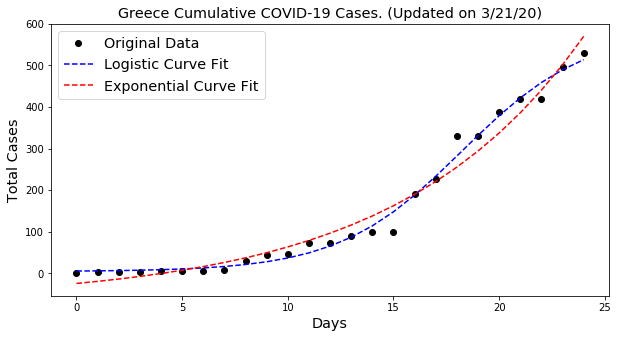



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 523
	Confirmed cases on 3/14/20 	 225
	Ratio: 2.32
	Weekly increase: 132.4 %
	Daily increase: 12.8 % per day
	Doubling Time (represents recent growth): 5.8 days

** Based on Exponential Fit **

	R^2: 0.973193146609
	Doubling Time (represents overall growth):  4.05 (± 0.39 ) days


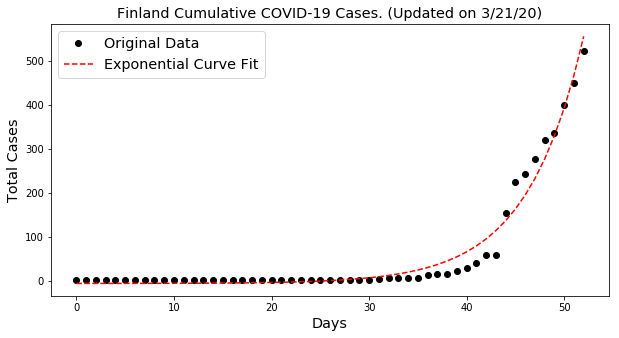



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 506
	Confirmed cases on 3/14/20 	 28
	Ratio: 18.07
	Weekly increase: 1707.1 %
	Daily increase: 51.2 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.990125617521
	Doubling Time (represents overall growth):  1.39 (± 0.14 ) days


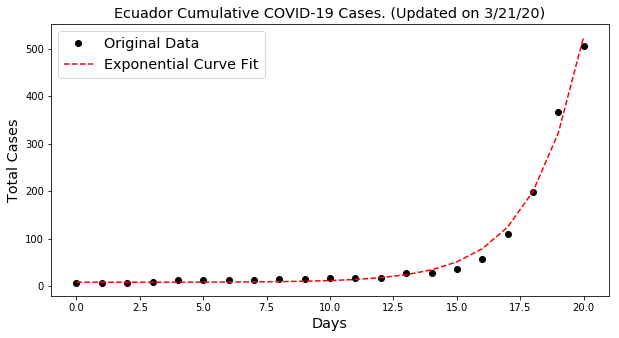



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 481
	Confirmed cases on 3/14/20 	 337
	Ratio: 1.43
	Weekly increase: 42.7 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.977603004497
	Doubling Time (during middle of growth):  1.94 (± 0.64 ) days


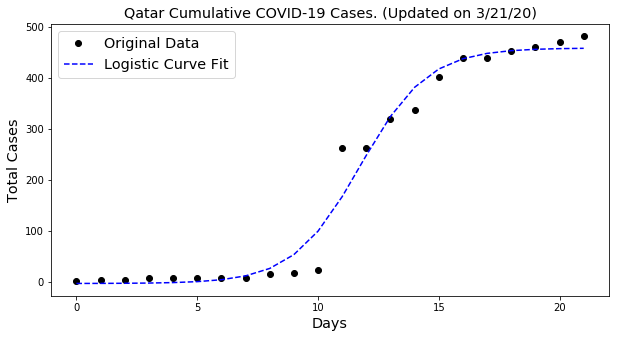



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 473
	Confirmed cases on 3/14/20 	 156
	Ratio: 3.03
	Weekly increase: 203.2 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.992755808953
	Doubling Time (during middle of growth):  8.18 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.992755809194
	Doubling Time (represents overall growth):  4.09 (± 0.41 ) days


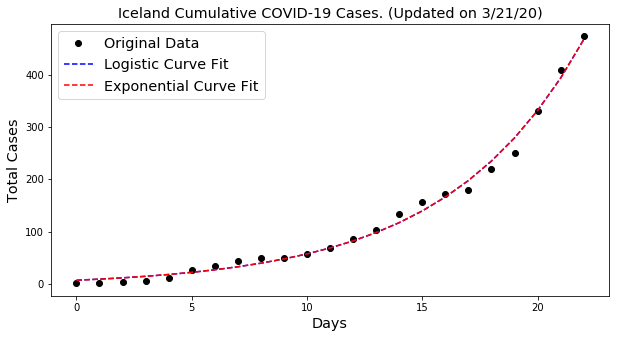



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 450
	Confirmed cases on 3/14/20 	 96
	Ratio: 4.69
	Weekly increase: 368.8 %
	Daily increase: 24.7 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.997124352444
	Doubling Time (during middle of growth):  4.88 (± 0.95 ) days

** Based on Exponential Fit **

	R^2: 0.996190003174
	Doubling Time (represents overall growth):  3.1 (± 0.23 ) days


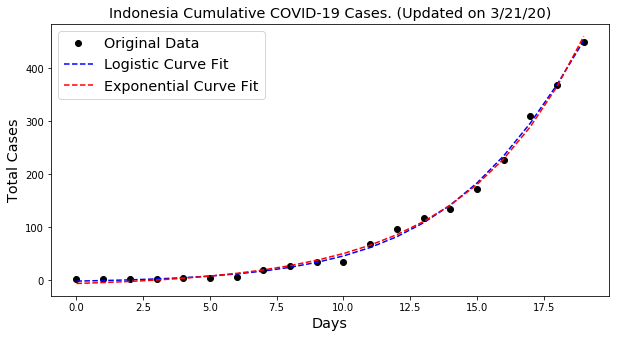



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 432
	Confirmed cases on 3/14/20 	 212
	Ratio: 2.04
	Weekly increase: 103.8 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.963375530764
	Doubling Time (during middle of growth):  18.11 (± 4.81 ) days

** Based on Exponential Fit **

	R^2: 0.963375532114
	Doubling Time (represents overall growth):  9.05 (± 1.15 ) days


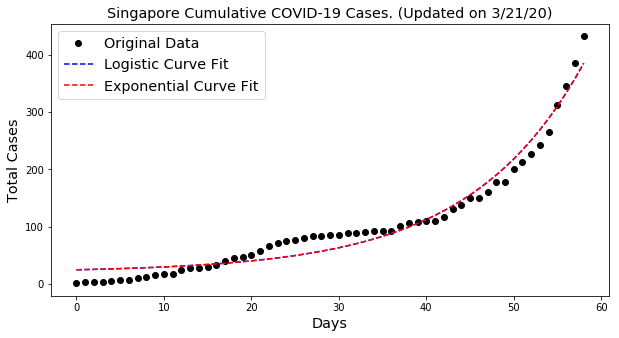



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 411
	Confirmed cases on 3/14/20 	 82
	Ratio: 5.01
	Weekly increase: 401.2 %
	Daily increase: 25.9 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.981037060031
	Doubling Time (represents overall growth):  2.91 (± 0.21 ) days


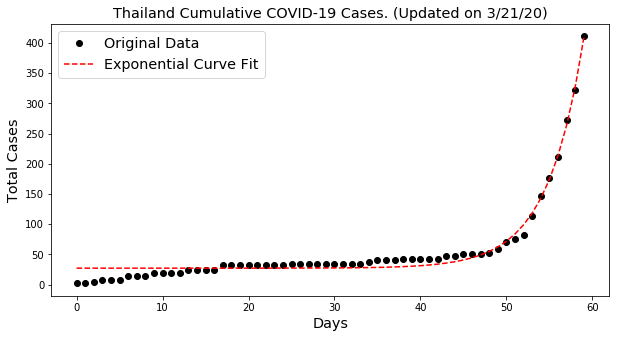



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 392
	Confirmed cases on 3/14/20 	 103
	Ratio: 3.81
	Weekly increase: 280.6 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.986497032047
	Doubling Time (during middle of growth):  5.94 (± 3.06 ) days

** Based on Exponential Fit **

	R^2: 0.986403549318
	Doubling Time (represents overall growth):  3.23 (± 0.46 ) days


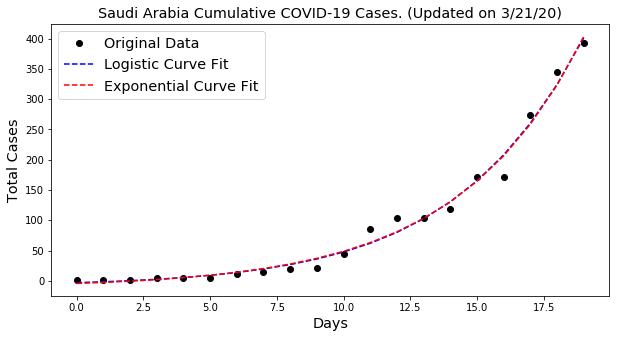



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 383
	Confirmed cases on 3/14/20 	 181
	Ratio: 2.12
	Weekly increase: 111.6 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.984645572738
	Doubling Time (during middle of growth):  3.49 (± 1.25 ) days

** Based on Exponential Fit **

	R^2: 0.956140294199
	Doubling Time (represents overall growth):  6.83 (± 3.81 ) days


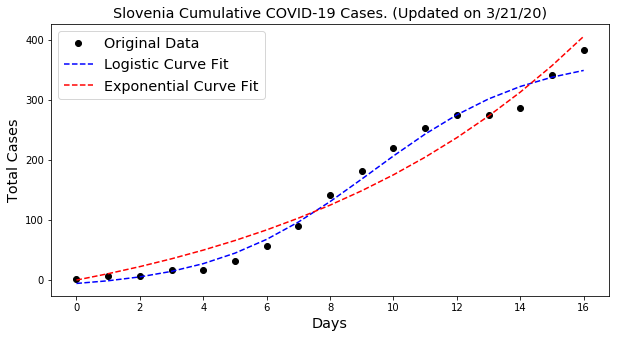



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 367
	Confirmed cases on 3/14/20 	 123
	Ratio: 2.98
	Weekly increase: 198.4 %
	Daily increase: 16.9 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Logistic Fit**

	R^2: 0.994004534472
	Doubling Time (during middle of growth):  4.42 (± 0.82 ) days

** Based on Exponential Fit **

	R^2: 0.985709134567
	Doubling Time (represents overall growth):  4.07 (± 0.52 ) days


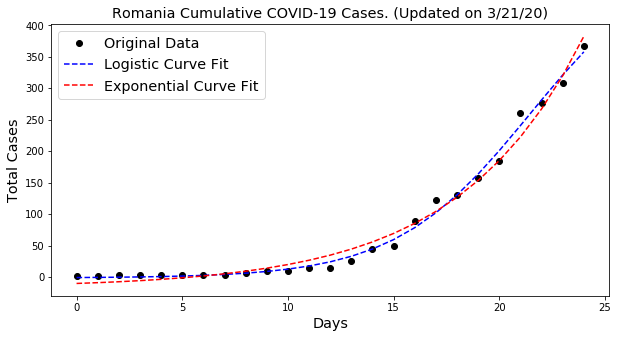



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 330
	Confirmed cases on 3/14/20 	 102
	Ratio: 3.24
	Weekly increase: 223.5 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Exponential Fit **

	R^2: 0.98696042077
	Doubling Time (represents overall growth):  3.98 (± 0.27 ) days


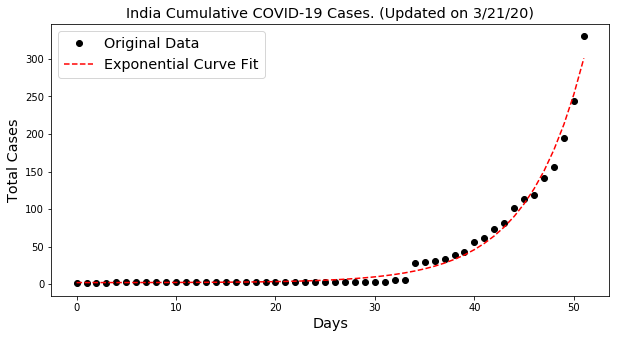



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 318
	Confirmed cases on 3/14/20 	 38
	Ratio: 8.37
	Weekly increase: 736.8 %
	Daily increase: 35.5 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.988078123596
	Doubling Time (during middle of growth):  3.06 (± 1.12 ) days

** Based on Exponential Fit **

	R^2: 0.982023490689
	Doubling Time (represents overall growth):  2.81 (± 0.56 ) days


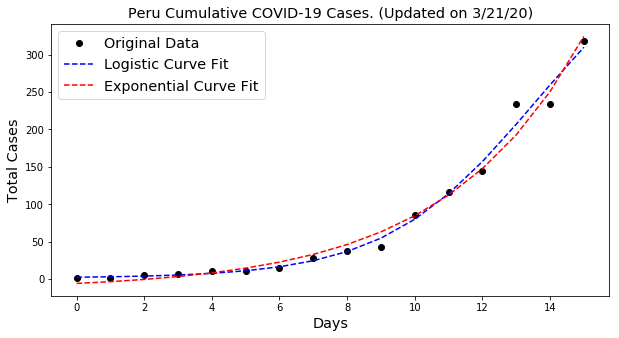



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 307
	Confirmed cases on 3/14/20 	 111
	Ratio: 2.77
	Weekly increase: 176.6 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.975132076375
	Doubling Time (represents overall growth):  3.98 (± 0.37 ) days


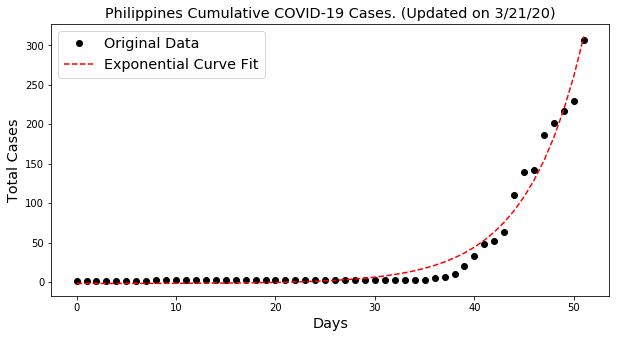



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 306
	Confirmed cases on 3/14/20 	 59
	Ratio: 5.19
	Weekly increase: 418.6 %
	Daily increase: 26.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.997897991182
	Doubling Time (represents overall growth):  2.75 (± 0.07 ) days


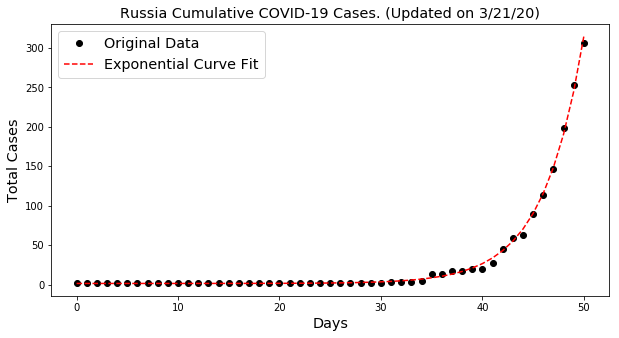



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 306
	Confirmed cases on 3/14/20 	 115
	Ratio: 2.66
	Weekly increase: 166.1 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.994006537432
	Doubling Time (during middle of growth):  2.07 (± 0.33 ) days


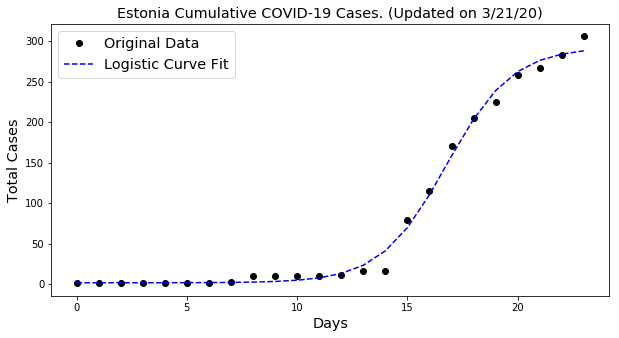



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 305
	Confirmed cases on 3/14/20 	 210
	Ratio: 1.45
	Weekly increase: 45.2 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 13.0 days

** Based on Logistic Fit**

	R^2: 0.973399002179
	Doubling Time (during middle of growth):  5.75 (± 2.13 ) days

** Based on Exponential Fit **

	R^2: 0.961124818413
	Doubling Time (represents overall growth):  12.73 (± 5.69 ) days


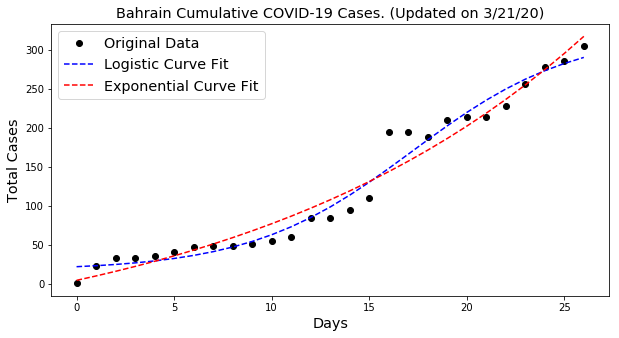



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 294
	Confirmed cases on 3/14/20 	 109
	Ratio: 2.7
	Weekly increase: 169.7 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.990313628048
	Doubling Time (during middle of growth):  5.76 (± 1.1 ) days

** Based on Exponential Fit **

	R^2: 0.984716655725
	Doubling Time (represents overall growth):  4.46 (± 0.43 ) days


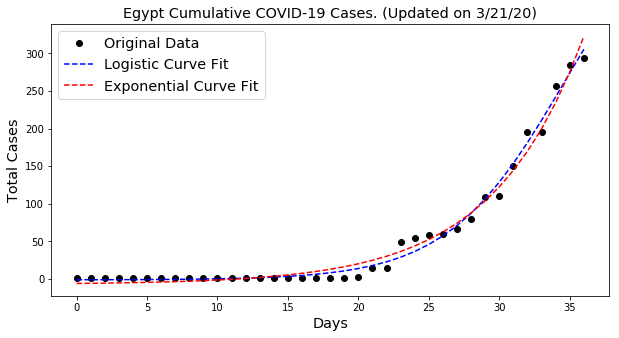



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 240
	Confirmed cases on 3/14/20 	 38
	Ratio: 6.32
	Weekly increase: 531.6 %
	Daily increase: 30.1 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.99248428202
	Doubling Time (during middle of growth):  3.94 (± 1.32 ) days

** Based on Exponential Fit **

	R^2: 0.991199788965
	Doubling Time (represents overall growth):  2.63 (± 0.33 ) days


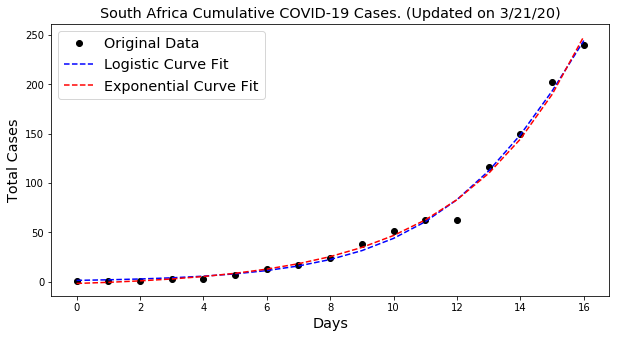



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 214
	Confirmed cases on 3/14/20 	 110
	Ratio: 1.95
	Weekly increase: 94.5 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.992374676873
	Doubling Time (during middle of growth):  15.35 (± 3.84 ) days

** Based on Exponential Fit **

	R^2: 0.992374677011
	Doubling Time (represents overall growth):  7.68 (± 0.98 ) days


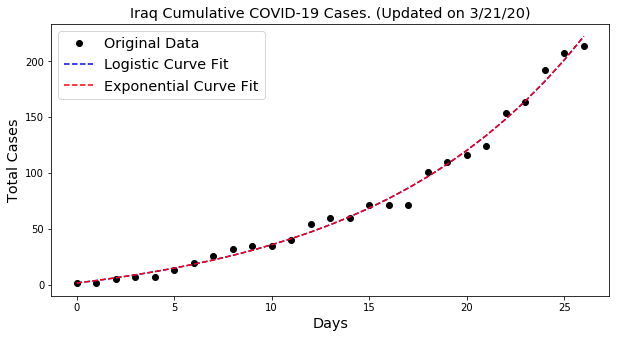



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 206
	Confirmed cases on 3/14/20 	 38
	Ratio: 5.42
	Weekly increase: 442.1 %
	Daily increase: 27.3 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.985114118537
	Doubling Time (represents overall growth):  2.44 (± 0.27 ) days


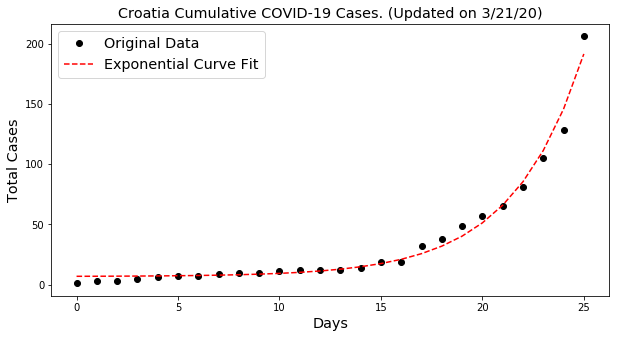



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 203
	Confirmed cases on 3/14/20 	 26
	Ratio: 7.81
	Weekly increase: 680.8 %
	Daily increase: 34.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.995415607141
	Doubling Time (during middle of growth):  3.62 (± 0.66 ) days

** Based on Exponential Fit **

	R^2: 0.992612222385
	Doubling Time (represents overall growth):  2.5 (± 0.21 ) days


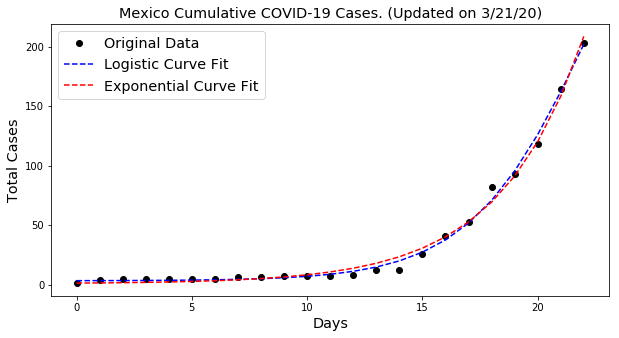



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 200
	Confirmed cases on 3/14/20 	 36
	Ratio: 5.56
	Weekly increase: 455.6 %
	Daily increase: 27.8 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.989503852993
	Doubling Time (during middle of growth):  5.6 (± 2.47 ) days

** Based on Exponential Fit **

	R^2: 0.989503854303
	Doubling Time (represents overall growth):  2.8 (± 0.6 ) days


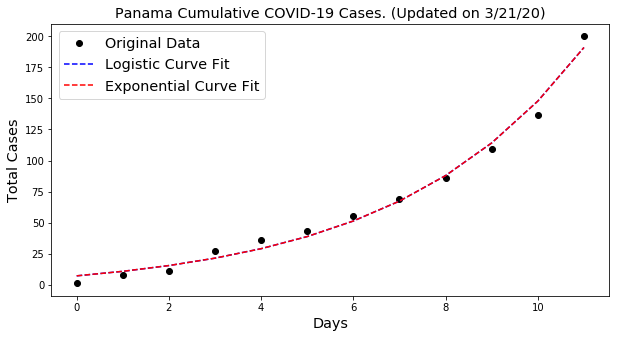



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 196
	Confirmed cases on 3/14/20 	 22
	Ratio: 8.91
	Weekly increase: 790.9 %
	Daily increase: 36.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.9881123
	Doubling Time (during middle of growth):  5.26 (± 1.72 ) days

** Based on Exponential Fit **

	R^2: 0.988112300537
	Doubling Time (represents overall growth):  2.63 (± 0.41 ) days


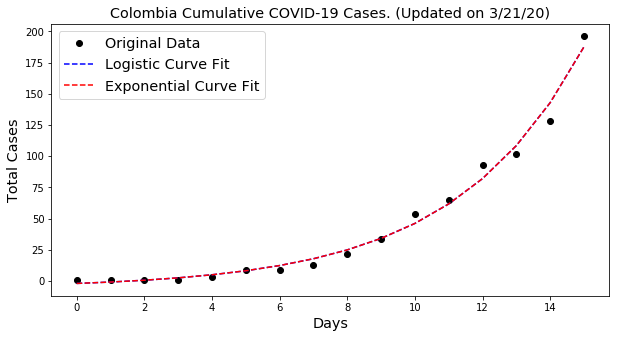



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 187
	Confirmed cases on 3/14/20 	 93
	Ratio: 2.01
	Weekly increase: 101.1 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.992885592934
	Doubling Time (during middle of growth):  7.19 (± 1.54 ) days

** Based on Exponential Fit **

	R^2: 0.988746441965
	Doubling Time (represents overall growth):  6.31 (± 0.75 ) days


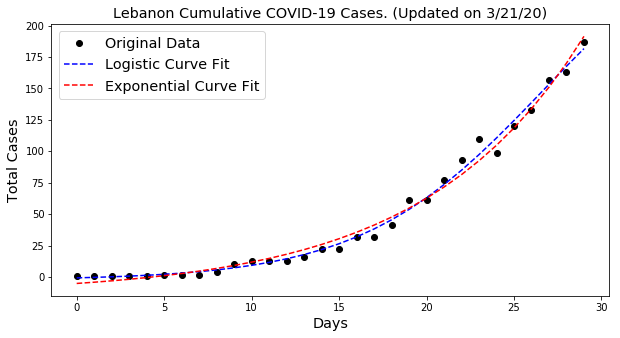



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 178
	Confirmed cases on 3/14/20 	 44
	Ratio: 4.05
	Weekly increase: 304.5 %
	Daily increase: 22.1 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.992794625494
	Doubling Time (during middle of growth):  6.15 (± 3.35 ) days

** Based on Exponential Fit **

	R^2: 0.992386815256
	Doubling Time (represents overall growth):  3.99 (± 0.63 ) days


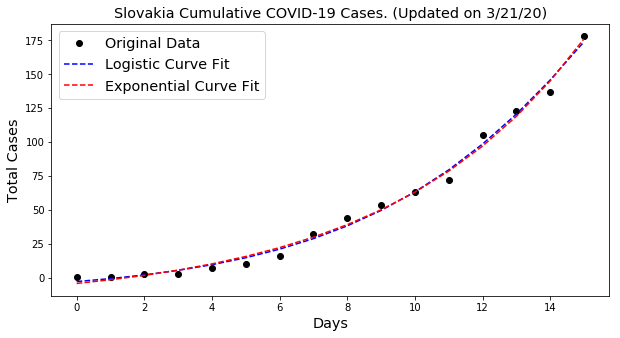



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 176
	Confirmed cases on 3/14/20 	 104
	Ratio: 1.69
	Weekly increase: 69.2 %
	Daily increase: 7.8 % per day
	Doubling Time (represents recent growth): 9.2 days

** Based on Logistic Fit**

	R^2: 0.958742832592
	Doubling Time (during middle of growth):  17.78 (± 14.37 ) days

** Based on Exponential Fit **

	R^2: 0.958742833822
	Doubling Time (represents overall growth):  8.89 (± 3.01 ) days


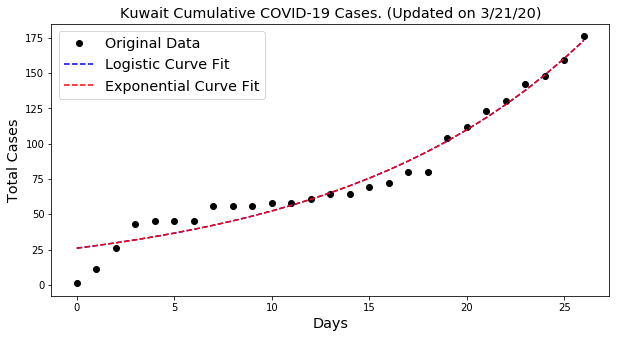



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 171
	Confirmed cases on 3/14/20 	 46
	Ratio: 3.72
	Weekly increase: 271.7 %
	Daily increase: 20.6 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.989976936232
	Doubling Time (during middle of growth):  7.05 (± 1.04 ) days

** Based on Exponential Fit **

	R^2: 0.989976936582
	Doubling Time (represents overall growth):  3.52 (± 0.59 ) days


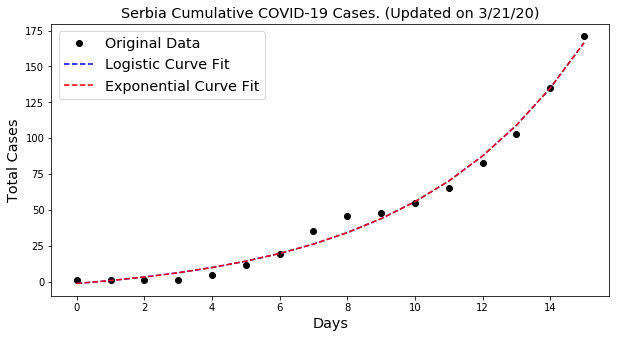



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 163
	Confirmed cases on 3/14/20 	 41
	Ratio: 3.98
	Weekly increase: 297.6 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.984560943016
	Doubling Time (during middle of growth):  7.7 (± 6.55 ) days

** Based on Exponential Fit **

	R^2: 0.984560943288
	Doubling Time (represents overall growth):  3.85 (± 1.02 ) days


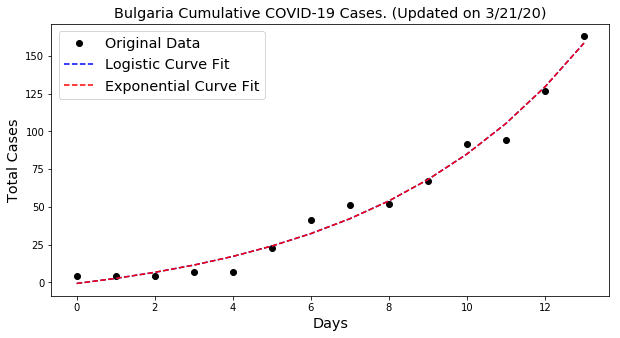



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 160
	Confirmed cases on 3/14/20 	 18
	Ratio: 8.89
	Weekly increase: 788.9 %
	Daily increase: 36.6 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.994372582741
	Doubling Time (during middle of growth):  2.64 (± 0.48 ) days

** Based on Exponential Fit **

	R^2: 0.976250485256
	Doubling Time (represents overall growth):  2.88 (± 0.5 ) days


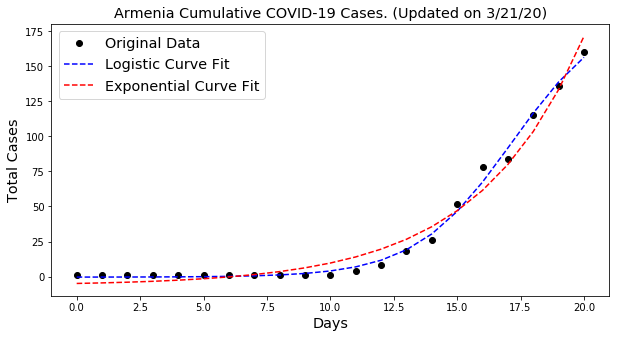



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 158
	Confirmed cases on 3/14/20 	 34
	Ratio: 4.65
	Weekly increase: 364.7 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.996766803982
	Doubling Time (during middle of growth):  6.69 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.99676680442
	Doubling Time (represents overall growth):  3.34 (± 0.25 ) days


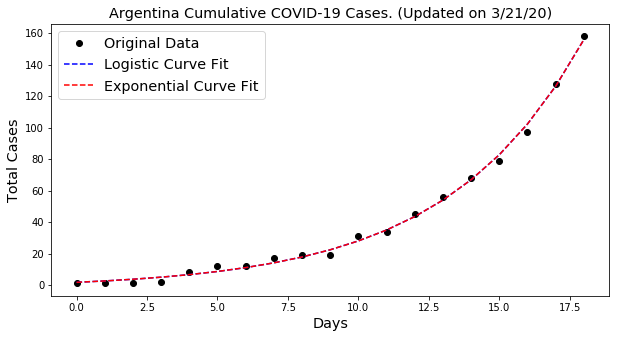



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 153
	Confirmed cases on 3/14/20 	 85
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.986111131903
	Doubling Time (during middle of growth):  9.22 (± 1.75 ) days

** Based on Exponential Fit **

	R^2: 0.981602154638
	Doubling Time (represents overall growth):  7.37 (± 0.67 ) days


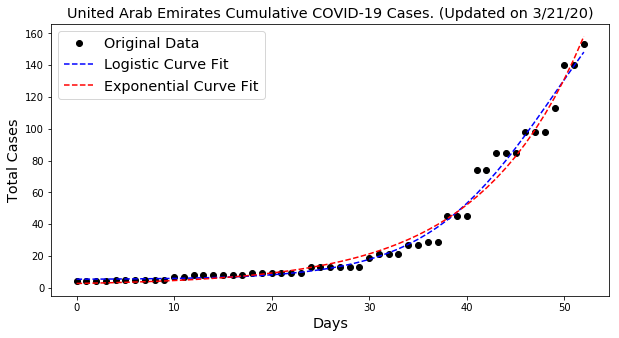



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 153
	Confirmed cases on 3/14/20 	 53
	Ratio: 2.89
	Weekly increase: 188.7 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days


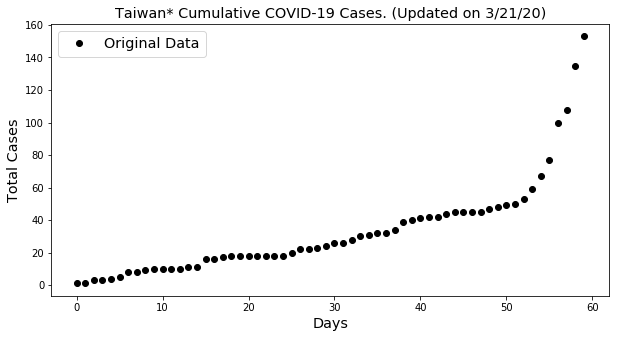



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 144
	Confirmed cases on 3/14/20 	 80
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.992394356514
	Doubling Time (during middle of growth):  6.69 (± 1.77 ) days

** Based on Exponential Fit **

	R^2: 0.985031127602
	Doubling Time (represents overall growth):  13.09 (± 4.38 ) days


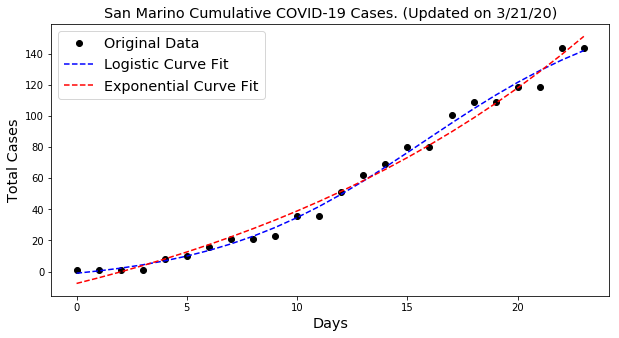



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 139
	Confirmed cases on 3/14/20 	 37
	Ratio: 3.76
	Weekly increase: 275.7 %
	Daily increase: 20.8 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.977213589033
	Doubling Time (during middle of growth):  7.7 (± 1.35 ) days

** Based on Exponential Fit **

	R^2: 0.977213589776
	Doubling Time (represents overall growth):  3.85 (± 0.59 ) days


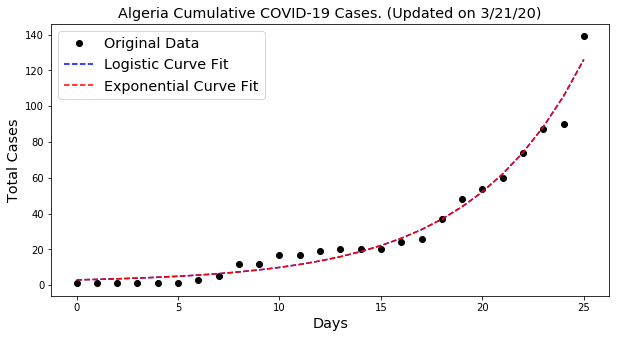



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 124
	Confirmed cases on 3/14/20 	 26
	Ratio: 4.77
	Weekly increase: 376.9 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.995785484155
	Doubling Time (during middle of growth):  3.85 (± 0.75 ) days

** Based on Exponential Fit **

	R^2: 0.99164321065
	Doubling Time (represents overall growth):  3.06 (± 0.34 ) days


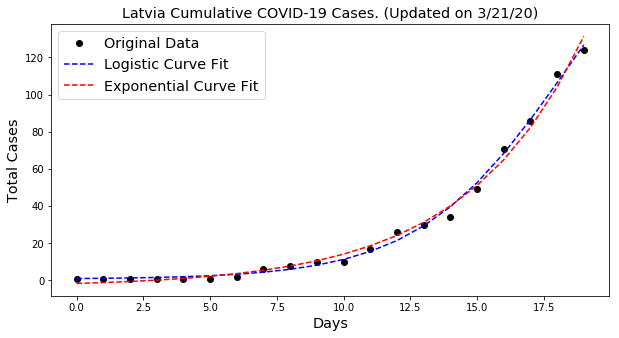



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 117
	Confirmed cases on 3/14/20 	 26
	Ratio: 4.5
	Weekly increase: 350.0 %
	Daily increase: 24.0 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.988095560939
	Doubling Time (during middle of growth):  5.6 (± 0.94 ) days

** Based on Exponential Fit **

	R^2: 0.988095561407
	Doubling Time (represents overall growth):  2.8 (± 0.45 ) days


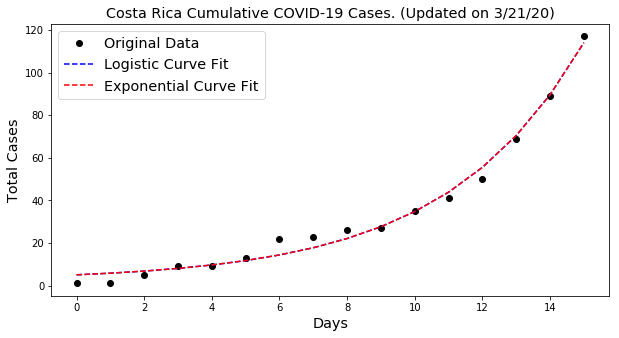



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 112
	Confirmed cases on 3/14/20 	 11
	Ratio: 10.18
	Weekly increase: 918.2 %
	Daily increase: 39.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.987625673002
	Doubling Time (represents overall growth):  1.29 (± 0.14 ) days


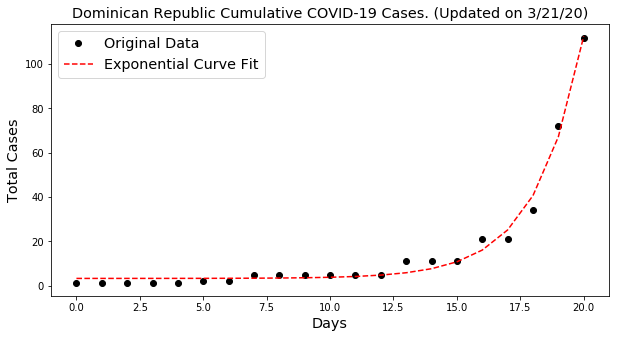



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 110
	Confirmed cases on 3/14/20 	 4
	Ratio: 27.5
	Weekly increase: 2650.0 %
	Daily increase: 60.6 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.996560717439
	Doubling Time (during middle of growth):  1.46 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.971535676589
	Doubling Time (represents overall growth):  4.93 (± 5.43 ) days


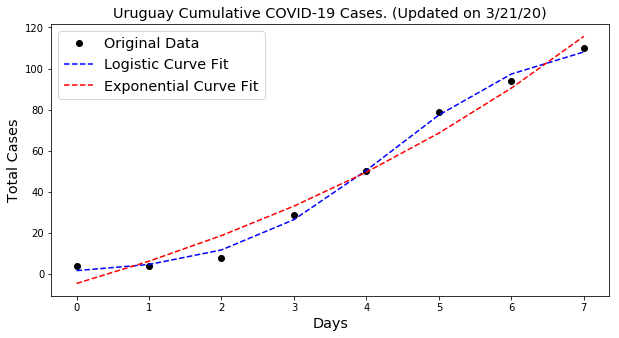



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 103
	Confirmed cases on 3/14/20 	 30
	Ratio: 3.43
	Weekly increase: 243.3 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.997339694225
	Doubling Time (during middle of growth):  6.17 (± 1.66 ) days

** Based on Exponential Fit **

	R^2: 0.996934880426
	Doubling Time (represents overall growth):  3.87 (± 0.33 ) days


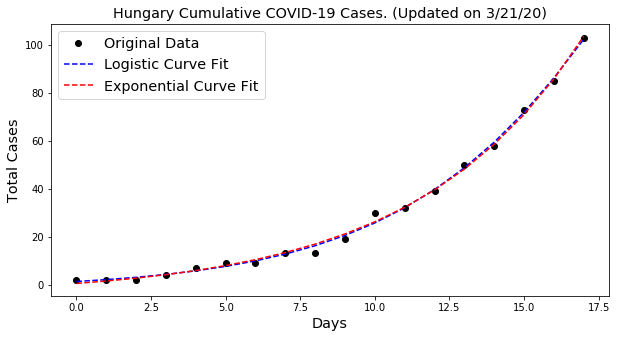

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


               Countries  Inferred Doubling Time  Recent Doubling Time
0                  China                     6.5                1200.3
1                  Italy                     4.6                   5.2
2                     US                     2.0                   2.2
3                  Spain                     3.3                   3.5
4                Germany                     3.0                   3.1
5                   Iran                     7.5                  10.1
6                 France                     3.8                   4.2
7           Korea, South                     4.3                  57.4
8            Switzerland                     3.2                   3.1
9         United Kingdom                     2.9                   3.3
10         

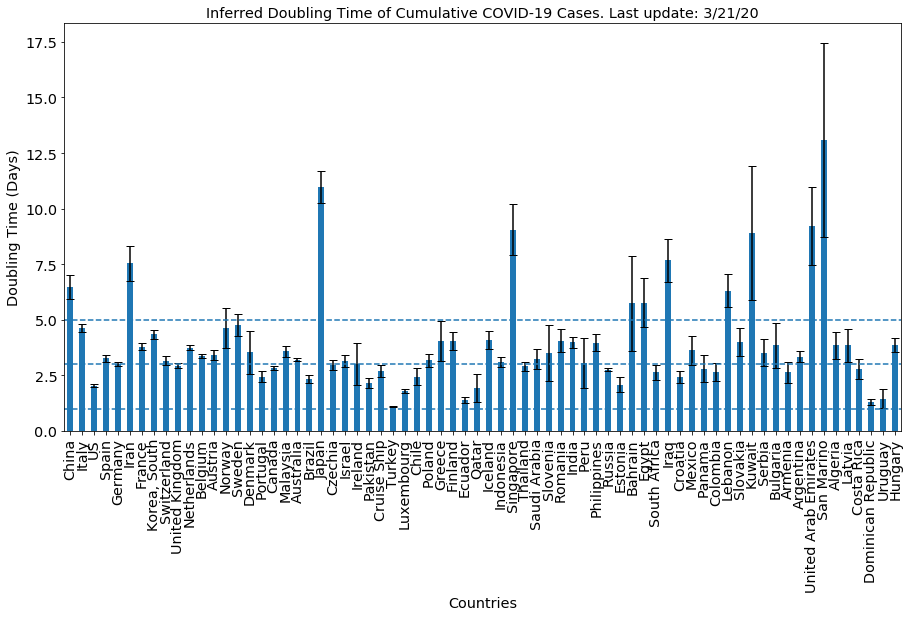

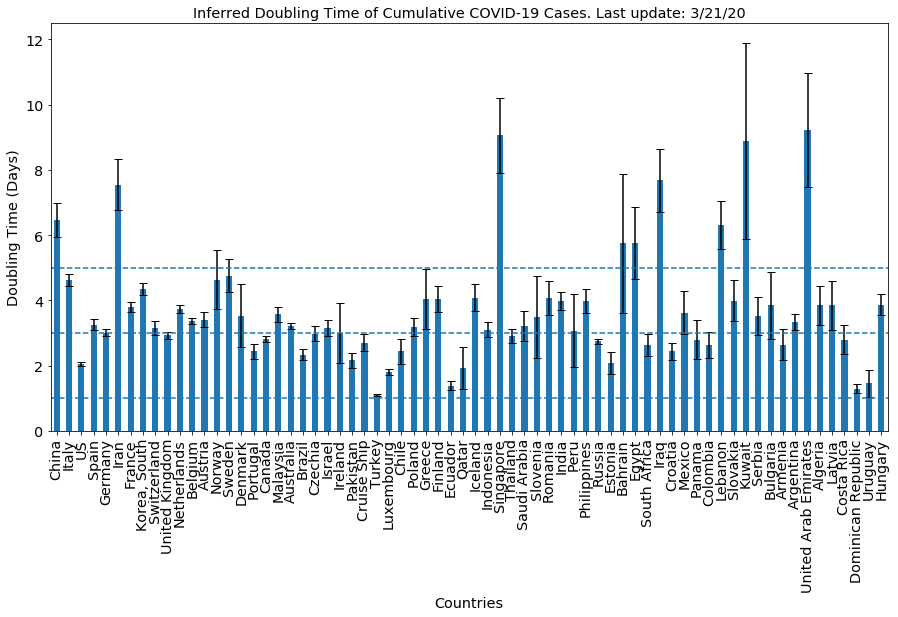

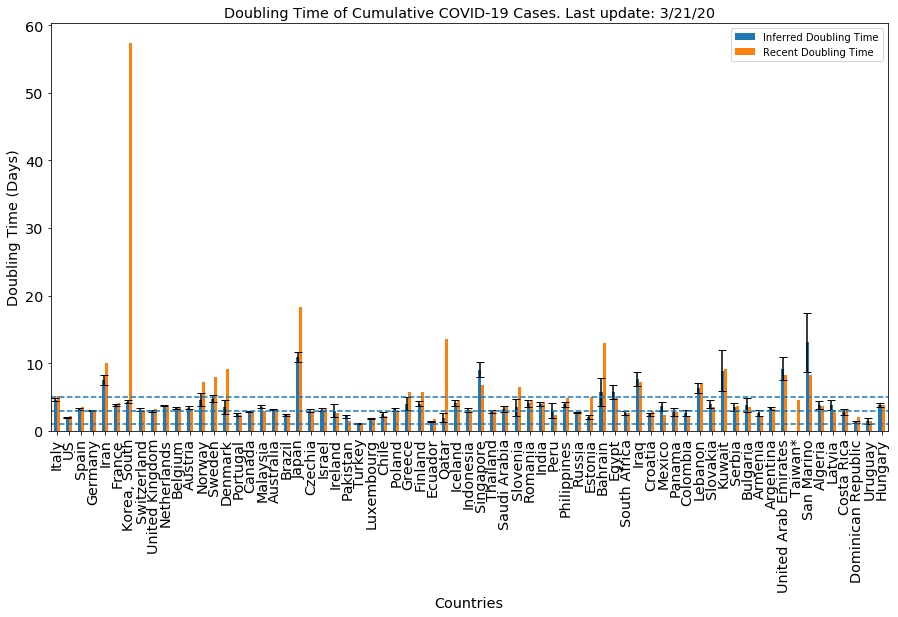

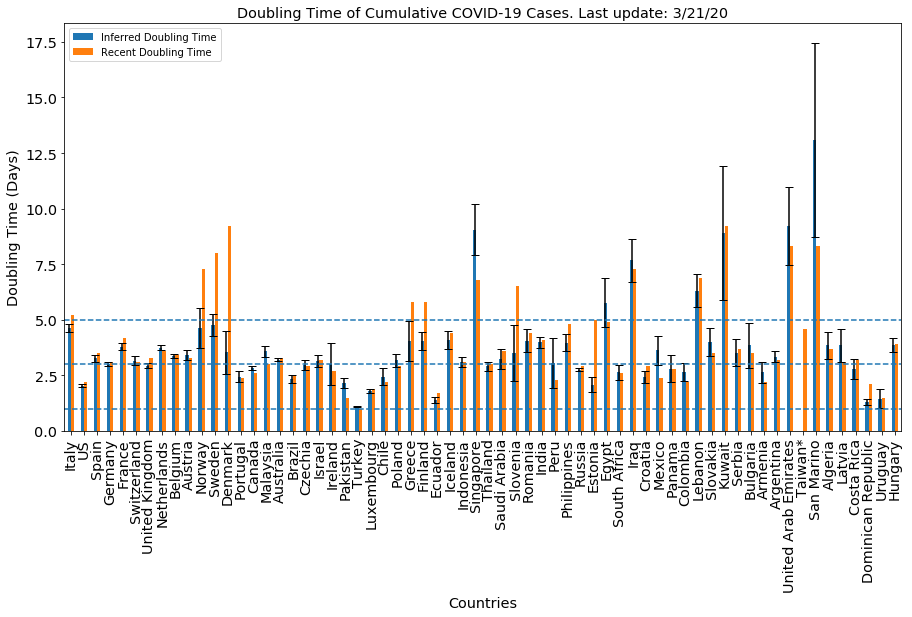

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/21/20


,3/21/20
Province/State,
New York,11710
Washington,1793
California,1364
New Jersey,1327
Michigan,788
Illinois,753
Florida,659
Louisiana,585
Texas,581


## Curve Fitting US COVID-19 Cases

                3/21/20
Province/State         
New York          11710
Washington         1793
California         1364
New Jersey         1327
Michigan            788
Illinois            753
Florida             659
Louisiana           585
Texas               581
Massachusetts       525
Georgia             507
Pennsylvania        396
Colorado            390
Tennessee           371
Wisconsin           282
North Carolina      253
Ohio                248
Connecticut         194
Maryland            193
South Carolina      171
Nevada              161
Virginia            156
Mississippi         140
Minnesota           138
Utah                136
Alabama             131
Indiana             128
Arkansas            122
Arizona             118
Oregon              114


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 11710
	Confirmed cases on 3/14/20 	 525
	Ratio: 22.3
	Weekly increase: 2130.5 %
	Daily increase: 55.8 % per day
	Doubling Time (represents

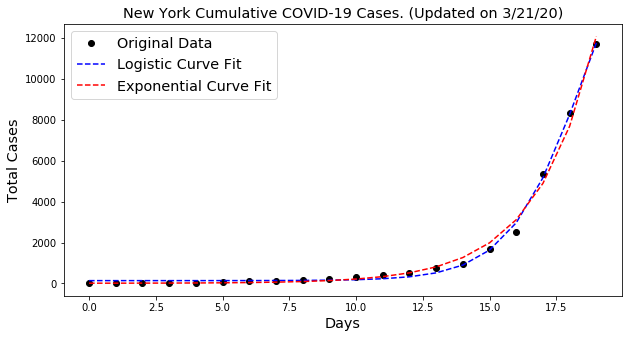



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1793
	Confirmed cases on 3/14/20 	 572
	Ratio: 3.13
	Weekly increase: 213.5 %
	Daily increase: 17.7 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Exponential Fit **

	R^2: 0.989174844434
	Doubling Time (represents overall growth):  4.14 (± 0.23 ) days


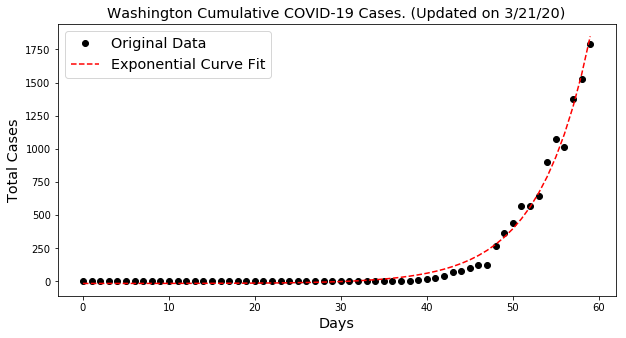



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1364
	Confirmed cases on 3/14/20 	 340
	Ratio: 4.01
	Weekly increase: 301.2 %
	Daily increase: 22.0 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.997608461299
	Doubling Time (represents overall growth):  3.49 (± 0.09 ) days


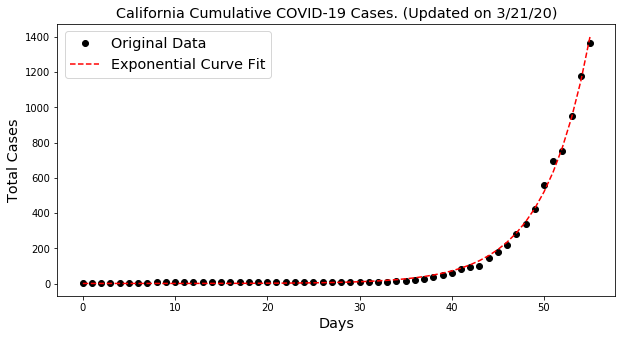



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 1327
	Confirmed cases on 3/14/20 	 69
	Ratio: 19.23
	Weekly increase: 1823.2 %
	Daily increase: 52.6 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.985369935091
	Doubling Time (during middle of growth):  2.56 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.983568657371
	Doubling Time (represents overall growth):  1.72 (± 0.26 ) days


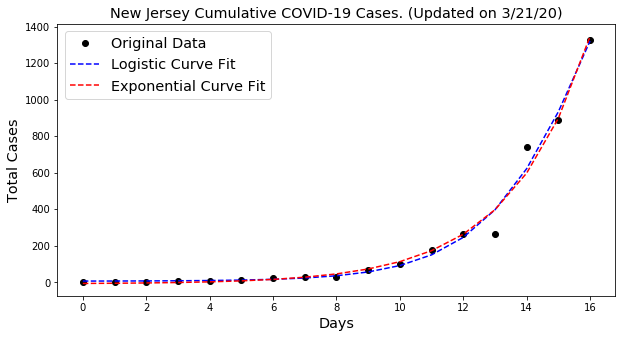



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 788
	Confirmed cases on 3/14/20 	 25
	Ratio: 31.52
	Weekly increase: 3052.0 %
	Daily increase: 63.7 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.9934634865
	Doubling Time (during middle of growth):  1.15 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.97734852059
	Doubling Time (represents overall growth):  1.38 (± 0.35 ) days


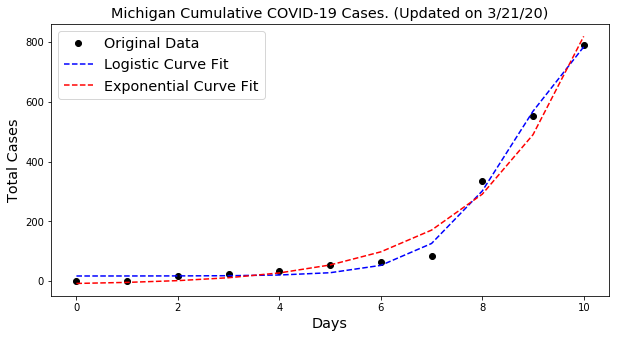



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 753
	Confirmed cases on 3/14/20 	 64
	Ratio: 11.77
	Weekly increase: 1076.6 %
	Daily increase: 42.2 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.985791853562
	Doubling Time (represents overall growth):  1.81 (± 0.12 ) days


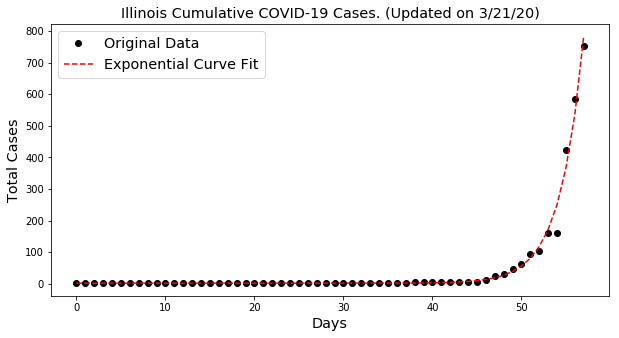



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 659
	Confirmed cases on 3/14/20 	 76
	Ratio: 8.67
	Weekly increase: 767.1 %
	Daily increase: 36.1 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.999085072009
	Doubling Time (during middle of growth):  3.14 (± 0.27 ) days

** Based on Exponential Fit **

	R^2: 0.993750510994
	Doubling Time (represents overall growth):  2.53 (± 0.22 ) days


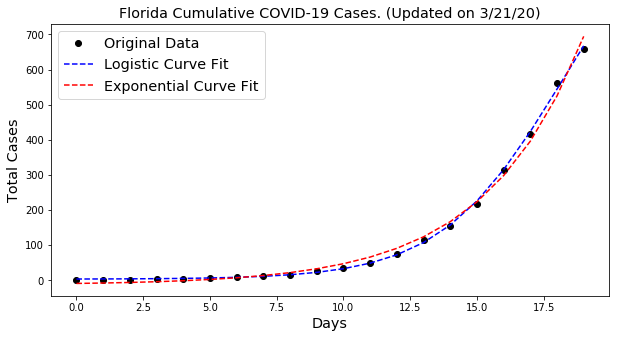



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 585
	Confirmed cases on 3/14/20 	 77
	Ratio: 7.6
	Weekly increase: 659.7 %
	Daily increase: 33.6 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.99340472852
	Doubling Time (during middle of growth):  2.74 (± 0.89 ) days

** Based on Exponential Fit **

	R^2: 0.986082488471
	Doubling Time (represents overall growth):  2.88 (± 0.66 ) days


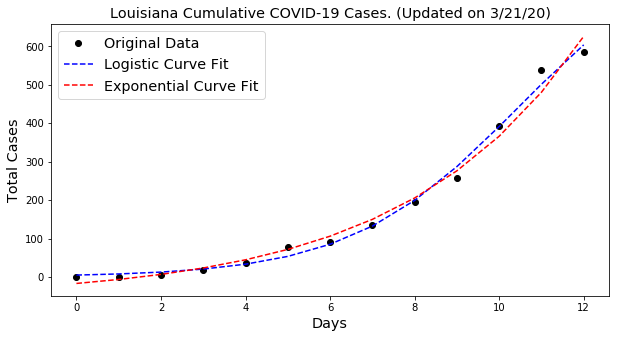



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 581
	Confirmed cases on 3/14/20 	 57
	Ratio: 10.19
	Weekly increase: 919.3 %
	Daily increase: 39.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.99802229854
	Doubling Time (during middle of growth):  3.42 (± 0.28 ) days

** Based on Exponential Fit **

	R^2: 0.998022298584
	Doubling Time (represents overall growth):  1.71 (± 0.09 ) days


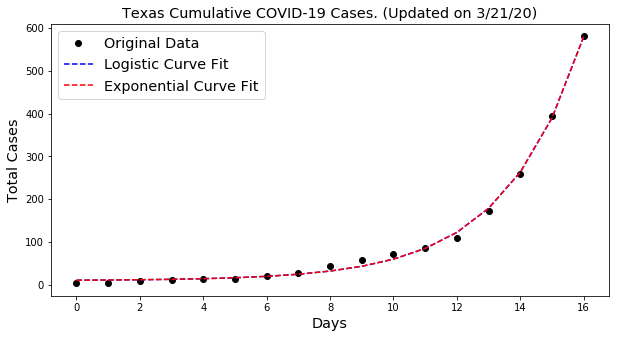



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 525
	Confirmed cases on 3/14/20 	 138
	Ratio: 3.8
	Weekly increase: 280.4 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.98376085218
	Doubling Time (represents overall growth):  3.48 (± 0.27 ) days


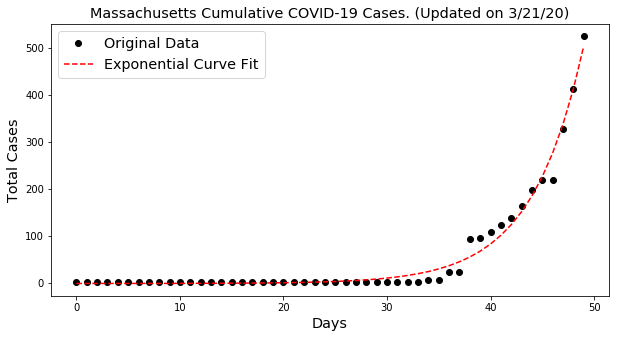



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 507
	Confirmed cases on 3/14/20 	 66
	Ratio: 7.68
	Weekly increase: 668.2 %
	Daily increase: 33.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.995760505986
	Doubling Time (during middle of growth):  4.09 (± 0.97 ) days

** Based on Exponential Fit **

	R^2: 0.99537787959
	Doubling Time (represents overall growth):  2.36 (± 0.18 ) days


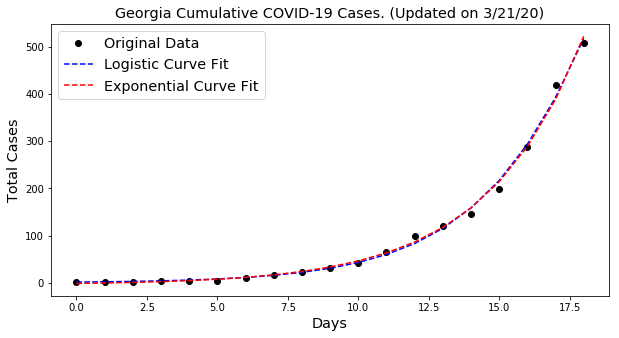



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 396
	Confirmed cases on 3/14/20 	 47
	Ratio: 8.43
	Weekly increase: 742.6 %
	Daily increase: 35.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.998210012004
	Doubling Time (during middle of growth):  4.42 (± 0.88 ) days

** Based on Exponential Fit **

	R^2: 0.99821001224
	Doubling Time (represents overall growth):  2.21 (± 0.12 ) days


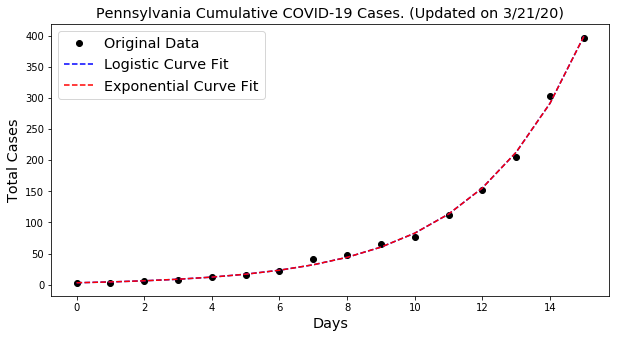



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 390
	Confirmed cases on 3/14/20 	 101
	Ratio: 3.86
	Weekly increase: 286.1 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.982724587858
	Doubling Time (during middle of growth):  6.11 (± 5.22 ) days

** Based on Exponential Fit **

	R^2: 0.982441337273
	Doubling Time (represents overall growth):  3.72 (± 0.86 ) days


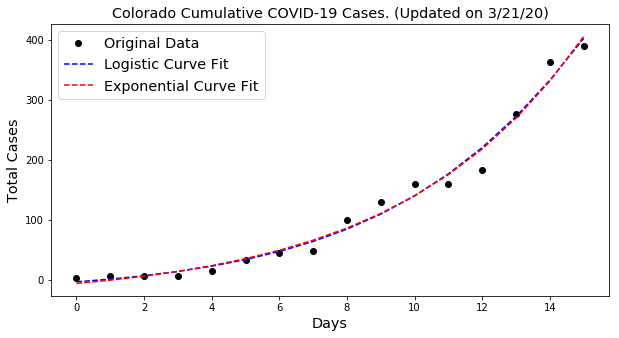



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 371
	Confirmed cases on 3/14/20 	 32
	Ratio: 11.59
	Weekly increase: 1059.4 %
	Daily increase: 41.9 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.993616585221
	Doubling Time (represents overall growth):  1.54 (± 0.14 ) days


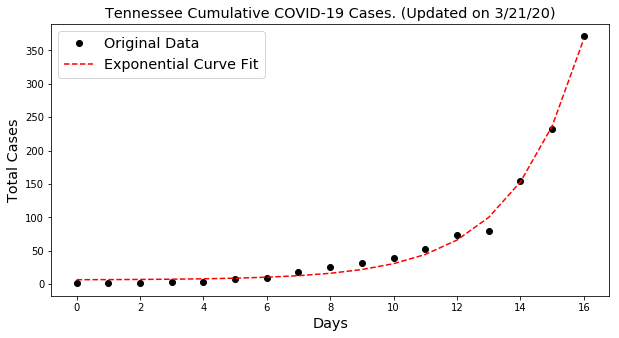



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 282
	Confirmed cases on 3/14/20 	 27
	Ratio: 10.44
	Weekly increase: 944.4 %
	Daily increase: 39.8 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.996689587016
	Doubling Time (during middle of growth):  3.15 (± 1.0 ) days

** Based on Exponential Fit **

	R^2: 0.995758481682
	Doubling Time (represents overall growth):  2.12 (± 0.25 ) days


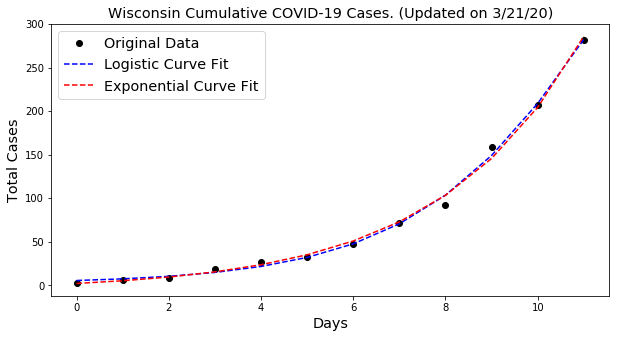



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 253
	Confirmed cases on 3/14/20 	 24
	Ratio: 10.54
	Weekly increase: 954.2 %
	Daily increase: 40.0 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.996295029126
	Doubling Time (represents overall growth):  1.85 (± 0.12 ) days


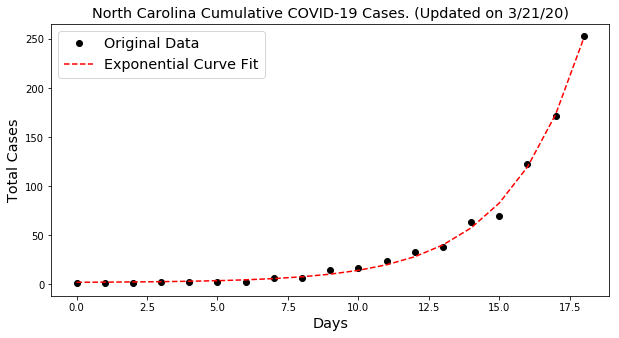



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 248
	Confirmed cases on 3/14/20 	 26
	Ratio: 9.54
	Weekly increase: 853.8 %
	Daily increase: 38.0 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.997106774051
	Doubling Time (during middle of growth):  4.21 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.997106774579
	Doubling Time (represents overall growth):  2.1 (± 0.2 ) days


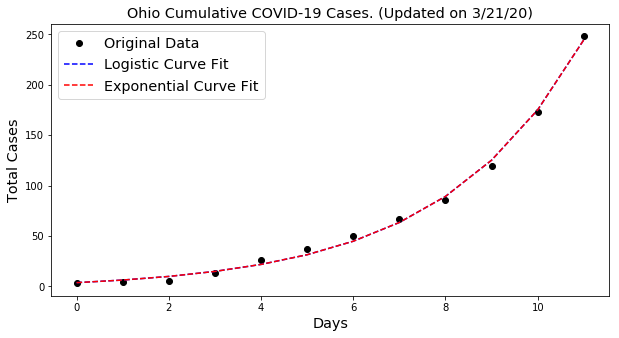



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 194
	Confirmed cases on 3/14/20 	 22
	Ratio: 8.82
	Weekly increase: 781.8 %
	Daily increase: 36.5 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.973151478276
	Doubling Time (during middle of growth):  1.41 (± 0.77 ) days


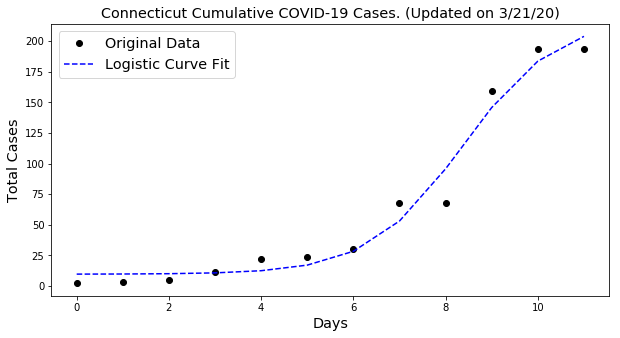



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 193
	Confirmed cases on 3/14/20 	 26
	Ratio: 7.42
	Weekly increase: 642.3 %
	Daily increase: 33.2 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.999136278676
	Doubling Time (during middle of growth):  4.06 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.998789318012
	Doubling Time (represents overall growth):  2.37 (± 0.11 ) days


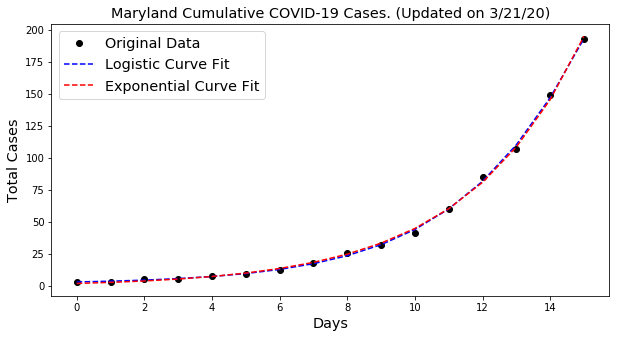



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 171
	Confirmed cases on 3/14/20 	 19
	Ratio: 9.0
	Weekly increase: 800.0 %
	Daily increase: 36.9 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.991255943274
	Doubling Time (during middle of growth):  3.77 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.99125594362
	Doubling Time (represents overall growth):  1.88 (± 0.24 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


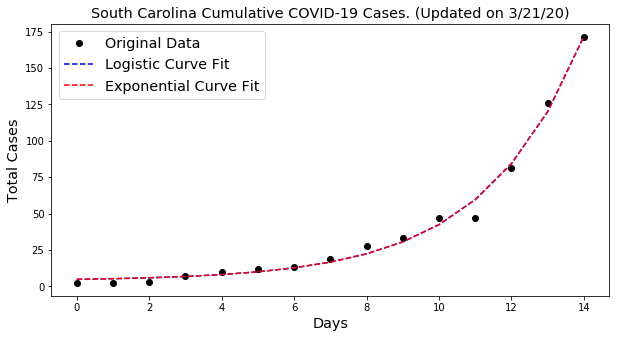



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 161
	Confirmed cases on 3/14/20 	 21
	Ratio: 7.67
	Weekly increase: 666.7 %
	Daily increase: 33.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.990511805585
	Doubling Time (during middle of growth):  4.85 (± 2.14 ) days

** Based on Exponential Fit **

	R^2: 0.990511806406
	Doubling Time (represents overall growth):  2.43 (± 0.3 ) days


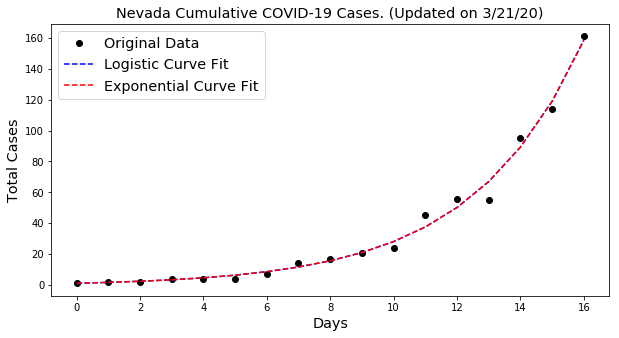



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 156
	Confirmed cases on 3/14/20 	 41
	Ratio: 3.8
	Weekly increase: 280.5 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9929714975
	Doubling Time (during middle of growth):  7.61 (± 1.93 ) days

** Based on Exponential Fit **

	R^2: 0.992971497906
	Doubling Time (represents overall growth):  3.81 (± 0.67 ) days


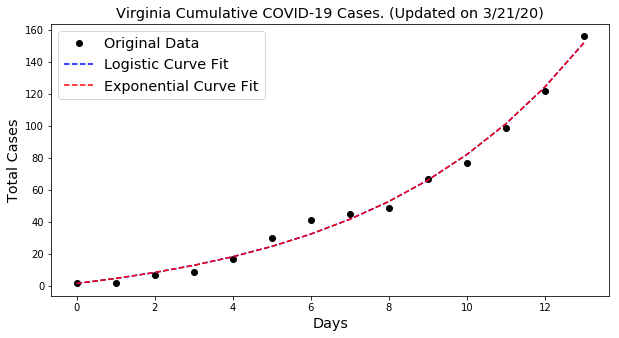



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 140
	Confirmed cases on 3/14/20 	 6
	Ratio: 23.33
	Weekly increase: 2233.3 %
	Daily increase: 56.8 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.997468204183
	Doubling Time (during middle of growth):  2.73 (± 0.28 ) days

** Based on Exponential Fit **

	R^2: 0.997468204315
	Doubling Time (represents overall growth):  1.37 (± 0.13 ) days


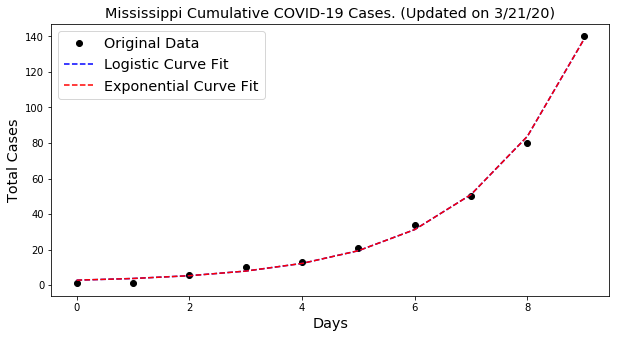



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 138
	Confirmed cases on 3/14/20 	 21
	Ratio: 6.57
	Weekly increase: 557.1 %
	Daily increase: 30.9 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.994513551935
	Doubling Time (during middle of growth):  4.18 (± 1.26 ) days

** Based on Exponential Fit **

	R^2: 0.991133624842
	Doubling Time (represents overall growth):  3.55 (± 0.56 ) days


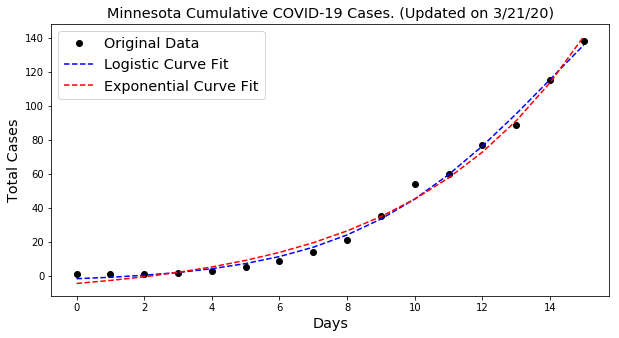



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 136
	Confirmed cases on 3/14/20 	 10
	Ratio: 13.6
	Weekly increase: 1260.0 %
	Daily increase: 45.2 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.96691867037
	Doubling Time (during middle of growth):  5.41 (± 9.52 ) days

** Based on Exponential Fit **

	R^2: 0.966918671178
	Doubling Time (represents overall growth):  2.71 (± 0.77 ) days


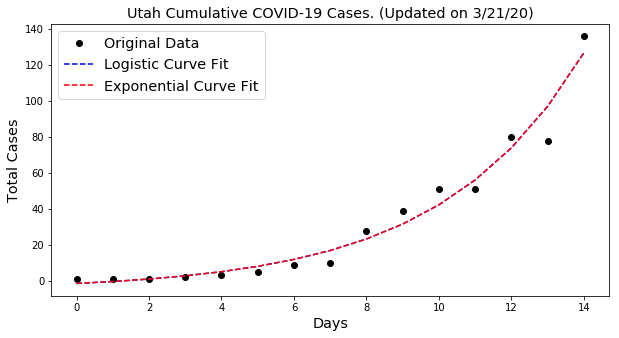



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 131
	Confirmed cases on 3/14/20 	 6
	Ratio: 21.83
	Weekly increase: 2083.3 %
	Daily increase: 55.3 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.979449557708
	Doubling Time (during middle of growth):  5.3 (± 4.19 ) days

** Based on Exponential Fit **

	R^2: 0.979449558103
	Doubling Time (represents overall growth):  2.65 (± 1.18 ) days


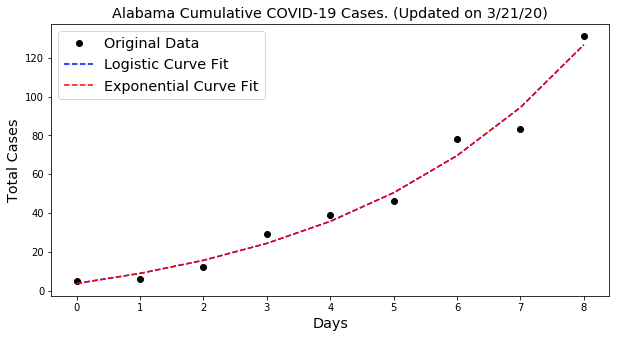



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 128
	Confirmed cases on 3/14/20 	 16
	Ratio: 8.0
	Weekly increase: 700.0 %
	Daily increase: 34.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.992234195341
	Doubling Time (during middle of growth):  3.66 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.992234196072
	Doubling Time (represents overall growth):  1.83 (± 0.2 ) days


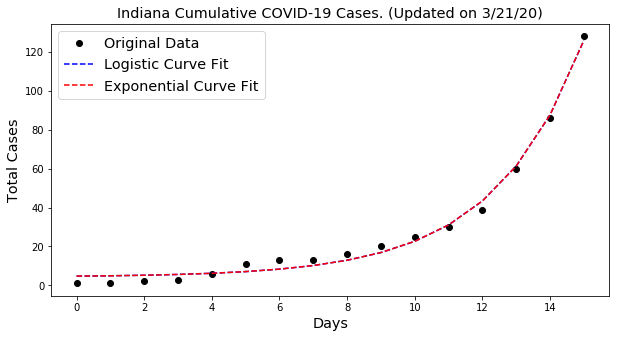



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 122
	Confirmed cases on 3/14/20 	 12
	Ratio: 10.17
	Weekly increase: 916.7 %
	Daily increase: 39.3 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.989537849282
	Doubling Time (during middle of growth):  1.95 (± 0.88 ) days

** Based on Exponential Fit **

	R^2: 0.985082226353
	Doubling Time (represents overall growth):  1.85 (± 0.42 ) days


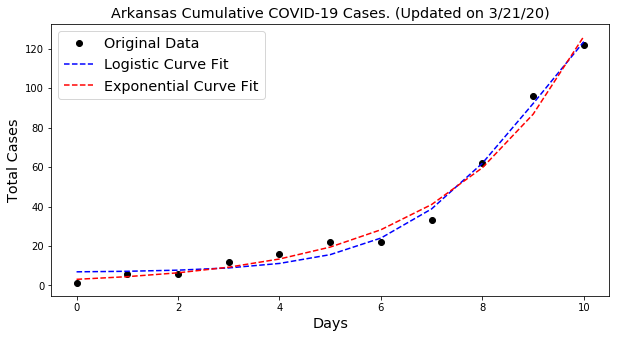



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 118
	Confirmed cases on 3/14/20 	 12
	Ratio: 9.83
	Weekly increase: 883.3 %
	Daily increase: 38.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.989395164791
	Doubling Time (represents overall growth):  1.58 (± 0.09 ) days


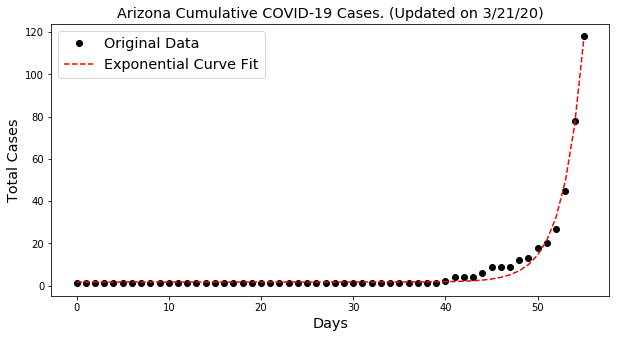



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/21/20 	 114
	Confirmed cases on 3/14/20 	 32
	Ratio: 3.56
	Weekly increase: 256.2 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.984404676029
	Doubling Time (during middle of growth):  5.98 (± 2.74 ) days

** Based on Exponential Fit **

	R^2: 0.983516386839
	Doubling Time (represents overall growth):  3.9 (± 0.61 ) days


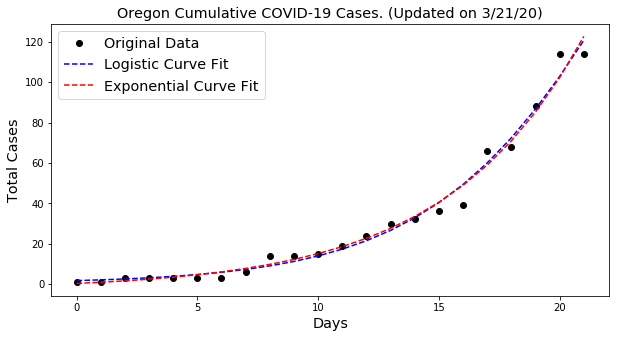

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


            States  Inferred Doubling Time  Recent Doubling Time
0         New York                     1.9                   1.6
1       Washington                     4.1                   4.2
2       California                     3.5                   3.5
3       New Jersey                     2.6                   1.6
4         Michigan                     1.2                   1.4
5         Illinois                     1.8                   2.0
6          Florida                     3.1                   2.2
7        Louisiana                     2.9                   2.4
8            Texas                     1.7                   2.1
9    Massachusetts                     3.5                   3.6
10         Georgia                     2.4                   2.4
11    Pennsy

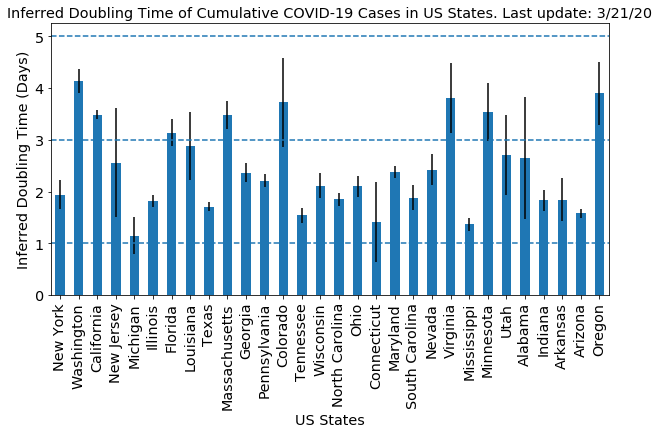

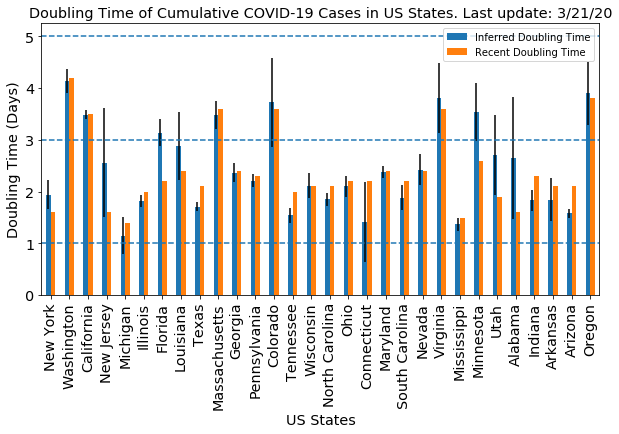

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()